# Compound Events
- use monthly pr instead of daily

In [1]:
# Imports
import os
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from collections import defaultdict

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 8
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['axes.linewidth'] = 0.1
plt.rcParams['patch.linewidth'] = 0

# Initialization

In [2]:
# filename format: CENTER_var_scenario_stat.csv

path = center = 'LARC' # Data directory
months = [6, 7, 8] # Dry months (June, July, August)
temporal_res = ['daily', 'monthly_avg', 'annual_avg'][0] # Temporal resolution 
variables = ['pr_', 'tasmax_']
hist = (1961, 1990) # Historical range
centers = ['AMES', 'GSFC', 'JPL', 'KSC', 'MSFC', 'MAF', 'GISS',
           'LARC', 'SSC', 'GRC', 'WFF', 'JSC', 'WSTF', 'AFRC']
percentiles = {
    'pr': ['<', 0.5], # 50th percentile for precipitation
    'tasmax': ['>', 0.9] # 90th percentile for maximum temperature
}

comp_ops = {
    '<': operator.lt,
    '<=': operator.le,
    '>': operator.gt,
    '>=': operator.ge,
    # '==': operator.eq,
    # '!=': operator.ne
    }

# Preprocess Data

In [3]:
def get_files(path: str, center: str, variables: list = None):
    '''
    Returns list of filenames in a directory that contain a specific string.

    Args:
        path: the path to the data directory to search
        center: the NASA center name in the filename
        variables: optional list of variables to filter files (default: None)
    '''
    return [os.path.join(path, f) for f in os.listdir(path) 
            if center in f and f.endswith('.csv') and any(v in f for v in variables)]


def preprocess_file(filename: str, is_hist: bool):
    '''
    Returns preprocessed pandas DataFrame based on CSV file type (historical or SSP)
    
    Args:
        filename: Path to the CSV file
        is_hist: Boolean indicating whether the file is historical (True) or SSP (False)
    
    Returns:
        - If historical: Processed DataFrame
        - If SSP: (variable name, processed DataFrame)
    '''
    name = filename[:-4].split('_')  # Extract variable name
    
    df = pd.read_csv(filename).rename(columns={'Unnamed: 0': 'date'})
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    
    if name[1] in ['pr']:
        # Calculate monthly mean per year while keeping original df dimensions
        df = df.groupby(df.index.strftime('%Y-%m')).transform('mean')
    
    # Convert Kelvin to Celsius for temperature data
    if name[1] in ['tasmax', 'tas']:
        df = df - 273.15

    if is_hist:
        # Calculate percentiles for each model
        op, p = percentiles[name[1]]
        df = df[(hist[0] <= df.index.year) & (df.index.year <= hist[1])]
        df = df.groupby(df.index.strftime('%Y-%m')).mean()
        return pd.DataFrame({f'{name[1]}_{op}_{p}': df.quantile(p)})
    else: 
        df = df[df.index.month.isin(months)]        
        return ('_'.join(name[1:3]), df.add_suffix(f'_{name[1]}'))

def add_compound_flag(hist_df, ssp_df):
    '''
    Returns SSP dataframe with added compound flag based on historical percentiles
    
    Args:
        hist_df: Historical DataFrame
        ssp_df: SSP DataFrame
    '''
    for model in hist_df.index:
        flag = []
        for var, (op, p) in percentiles.items():
            # Check if ssp values exceed historical percentiles
            perc = hist_df[f'{var}_{op}_{p}'].loc[model]
            ssp_values = ssp_df[f'{model}_{var}'].to_list()
            
            # Apply the comparison function
            ssp_df[f'{model}_{var}_{op}_{p}'] = comp_ops[op](ssp_values, perc)
            flag.append(ssp_df[f'{model}_{var}_{op}_{p}'])

            # Calculate severity
            ssp_df[f'{model}_{var}_severity'] = ssp_df[f'{model}_{var}'] - perc
            
        ssp_df[f'{model}_compound'] = np.all(flag, axis=0)
    return ssp_df

In [4]:
# Get files for a center
files = sorted([f for f in get_files(path, center, variables) if temporal_res in f])
files = {key: [f for f in files if key in f] for key in ['historical', 'ssp']}
print(f'{len(files['historical']) + len(files['ssp'])} {center} files')
display(files)

# Process historical files and merge into a single DataFrame
hist_df = pd.concat([preprocess_file(f, True) 
                     for f in files['historical']], axis=1).dropna()

# Process SSP files and store in a dictionary
ssp_dfs = {name: df for name, df in (preprocess_file(f, False) for f in files['ssp'])}

# Merge all SSP data from the same scenario
grouped_data = defaultdict(list)
for key, df in ssp_dfs.items():
    grouped_data[key.split('_')[-1]].append(df)
ssp_dfs = {ssp: pd.concat(dfs, axis=1) for ssp, dfs in grouped_data.items()}

# Add flag to indicate compound events
results = add_compound_flag(hist_df, ssp_dfs['ssp245'])

# # Dataframe column number check
# if ssp_dfs['ssp245'].shape[1] + len(hist_df) != results.shape[1]:
#     raise ValueError('Number of flag columns is incorrect')

print(f'\nHistorical percentiles: {len(hist_df)} models used')
display(hist_df.head(2))
print(f'SSP {temporal_res.title()} Data')
print(ssp_dfs.keys())
# display(ssp_dfs['ssp245'].head(2))
print('\nAdded Compound Flag')
display(results.head(2))

6 LARC files


{'historical': ['LARC/LARC_pr_historical_daily.csv',
  'LARC/LARC_tasmax_historical_daily.csv'],
 'ssp': ['LARC/LARC_pr_ssp126_daily.csv',
  'LARC/LARC_pr_ssp245_daily.csv',
  'LARC/LARC_pr_ssp370_daily.csv',
  'LARC/LARC_tasmax_ssp245_daily.csv']}


Historical percentiles: 21 models used


pr_<_0.5  tasmax_>_0.9
INM-CM4-8  0.000036     30.373966
INM-CM5-0  0.000036     30.351364

SSP Daily Data
dict_keys(['ssp126', 'ssp245', 'ssp370'])

Added Compound Flag


INM-CM4-8_pr  INM-CM5-0_pr  NorESM2-MM_pr  NorESM2-LM_pr  \
date                                                                   
2015-06-01      0.000047      0.000056       0.000038       0.000052   
2015-06-02      0.000047      0.000056       0.000038       0.000052   

            MIROC6_pr  GFDL-ESM4_pr  MIROC-ES2L_pr  GISS-E2-1-G_pr  \
date                                                                 
2015-06-01   0.000034      0.000043       0.000047        0.000032   
2015-06-02   0.000034      0.000043       0.000047        0.000032   

            FGOALS-g3_pr  MPI-ESM1-2-HR_pr  ...  CNRM-CM6-1_pr_<_0.5  \
date                                        ...                        
2015-06-01       0.00003          0.000043  ...                False   
2015-06-02       0.00003          0.000043  ...                False   

            CNRM-CM6-1_pr_severity  CNRM-CM6-1_tasmax_>_0.9  \
date                                                          
2015-06-01                0.000004                    False   
2015-06-02                0.000004                    False   

            CNRM-CM6-1_tasmax_severity  CNRM-CM6-1_compound  \
date                                                          
2015-06-01                   -5.282323                False   
2015-06-02                   -6.377073                False   

            KACE-1-0-G_pr_<_0.5  KACE-1-0-G_pr_severity  \
date                                                      
2015-06-01                False                0.000002   
2015-06-02                False                0.000002   

            KACE-1-0-G_tasmax_>_0.9  KACE-1-0-G_tasmax_severity  \
date                                                              
2015-06-01                     True                    1.390501   
2015-06-02                     True                    2.904082   

            KACE-1-0-G_compound  
date                             
2015-06-01                False  
2015-06-02                False  

[2 rows x 148 columns]

## Check

In [5]:
m = 'INM-CM4-8'
aa = results.filter(regex=m)#.sum()
display(hist_df.loc[m])
display(aa[aa[f'{m}_compound']==True].head(10))

pr_<_0.5         0.000036
tasmax_>_0.9    30.373966
Name: INM-CM4-8, dtype: float64

INM-CM4-8_pr  INM-CM4-8_tasmax  INM-CM4-8_pr_<_0.5  \
date                                                             
2017-07-06      0.000031         32.343103                True   
2017-07-07      0.000031         32.779413                True   
2017-07-08      0.000031         35.188318                True   
2017-07-09      0.000031         36.040735                True   
2017-07-10      0.000031         37.428766                True   
2017-07-11      0.000031         36.948480                True   
2017-07-12      0.000031         35.577600                True   
2017-07-13      0.000031         32.954218                True   
2017-07-14      0.000031         34.063837                True   
2017-07-15      0.000031         35.064905                True   

            INM-CM4-8_pr_severity  INM-CM4-8_tasmax_>_0.9  \
date                                                        
2017-07-06              -0.000005                    True   
2017-07-07              -0.000005                    True   
2017-07-08              -0.000005                    True   
2017-07-09              -0.000005                    True   
2017-07-10              -0.000005                    True   
2017-07-11              -0.000005                    True   
2017-07-12              -0.000005                    True   
2017-07-13              -0.000005                    True   
2017-07-14              -0.000005                    True   
2017-07-15              -0.000005                    True   

            INM-CM4-8_tasmax_severity  INM-CM4-8_compound  
date                                                       
2017-07-06                   1.969137                True  
2017-07-07                   2.405447                True  
2017-07-08                   4.814352                True  
2017-07-09                   5.666769                True  
2017-07-10                   7.054800                True  
2017-07-11                   6.574515                True  
2017-07-12                   5.203634                True  
2017-07-13                   2.580252                True  
2017-07-14                   3.689871                True  
2017-07-15                   4.690939                True

# Analysis

In [6]:
def plot_distribution(df, title_var):
    sns.kdeplot(data=df.mean(axis=1), label='mean', linewidth=0.5, alpha=0.7)
    sns.kdeplot(data=df.median(axis=1), label='median', linewidth=0.5, alpha=0.7)

    for col in df.columns:
        sns.kdeplot(data=df, x=col, #label=col.split('_')[0],
                    color='grey', linewidth=0.2, alpha=0.4)

    plt.title(f'Distribution: Mean+Median {title_var} Per (Month, Year) Across CMIP6 Models')
    plt.xlabel(title_var)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

def plot_ts(df, title_var, show_models=False):
    sns.lineplot(data=df.mean(axis=1), label='mean', linewidth=0.5, alpha=0.7)
    sns.lineplot(data=df.median(axis=1), label='median', linewidth=0.5, alpha=0.7)
    if show_models:
        for col in df.columns:
            sns.lineplot(data=df, x=df.index, y=col, #label=col.split('_')[0],
                         color='grey', linewidth=0.2, alpha=0.4)

    plt.title(f'TS: Mean+Median {title_var} Per Year Across CMIP6 Models')
    plt.xlabel('Year')
    plt.ylabel(title_var)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

## Compound

INM-CM4-8_compound  INM-CM5-0_compound  NorESM2-MM_compound  \
date                                                                      
2015-06-01                   0                   0                    0   
2015-07-01                   0                  22                   19   

            NorESM2-LM_compound  MIROC6_compound  GFDL-ESM4_compound  \
date                                                                   
2015-06-01                    0               15                   0   
2015-07-01                   22                0                   0   

            MIROC-ES2L_compound  GISS-E2-1-G_compound  FGOALS-g3_compound  \
date                                                                        
2015-06-01                    0                     3                   8   
2015-07-01                    0                     0                   0   

            MPI-ESM1-2-HR_compound  ...  MPI-ESM1-2-LR_compound  \
date                                ...                           
2015-06-01                       0  ...                      19   
2015-07-01                       0  ...                       0   

            MRI-ESM2-0_compound  CMCC-ESM2_compound  ACCESS-ESM1-5_compound  \
date                                                                          
2015-06-01                    0                   0                       0   
2015-07-01                   22                   0                      29   

            EC-Earth3_compound  ACCESS-CM2_compound  IPSL-CM6A-LR_compound  \
date                                                                         
2015-06-01                   0                    0                     22   
2015-07-01                   0                   24                      0   

            CNRM-ESM2-1_compound  CNRM-CM6-1_compound  KACE-1-0-G_compound  
date                                                                        
2015-06-01                     0                    0                    0  
2015-07-01                     0                    0                    0  

[2 rows x 21 columns]

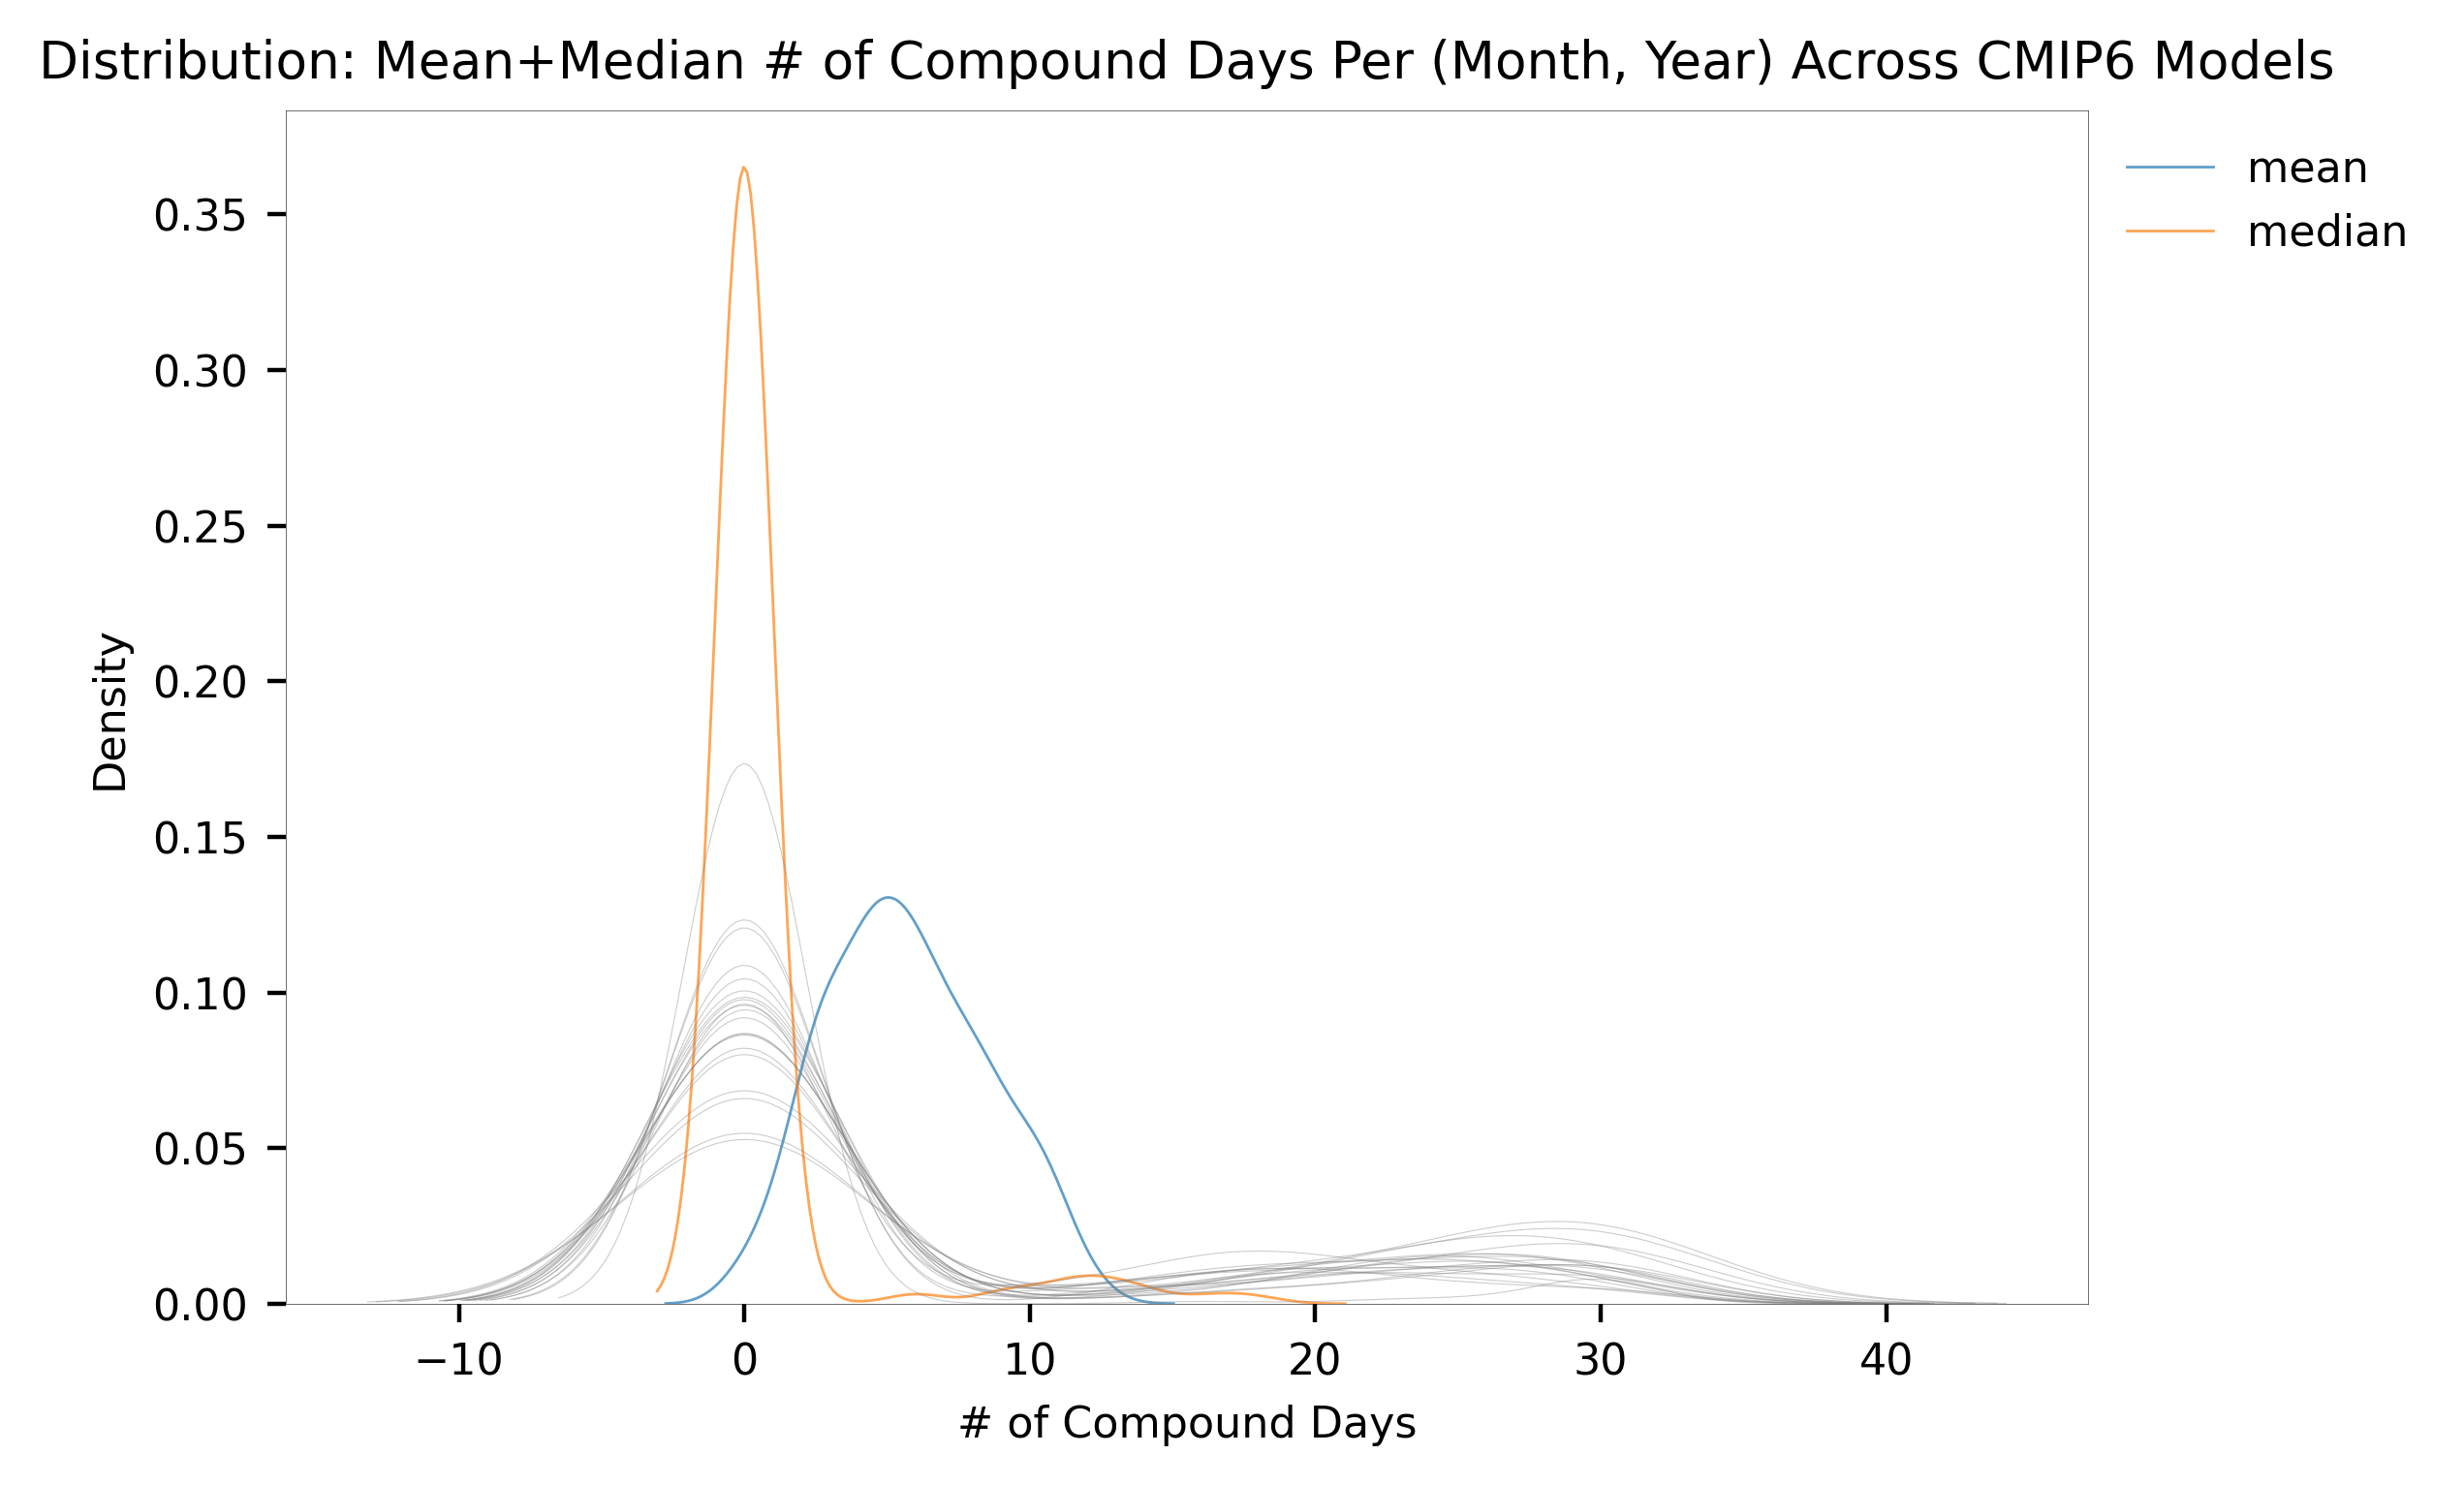

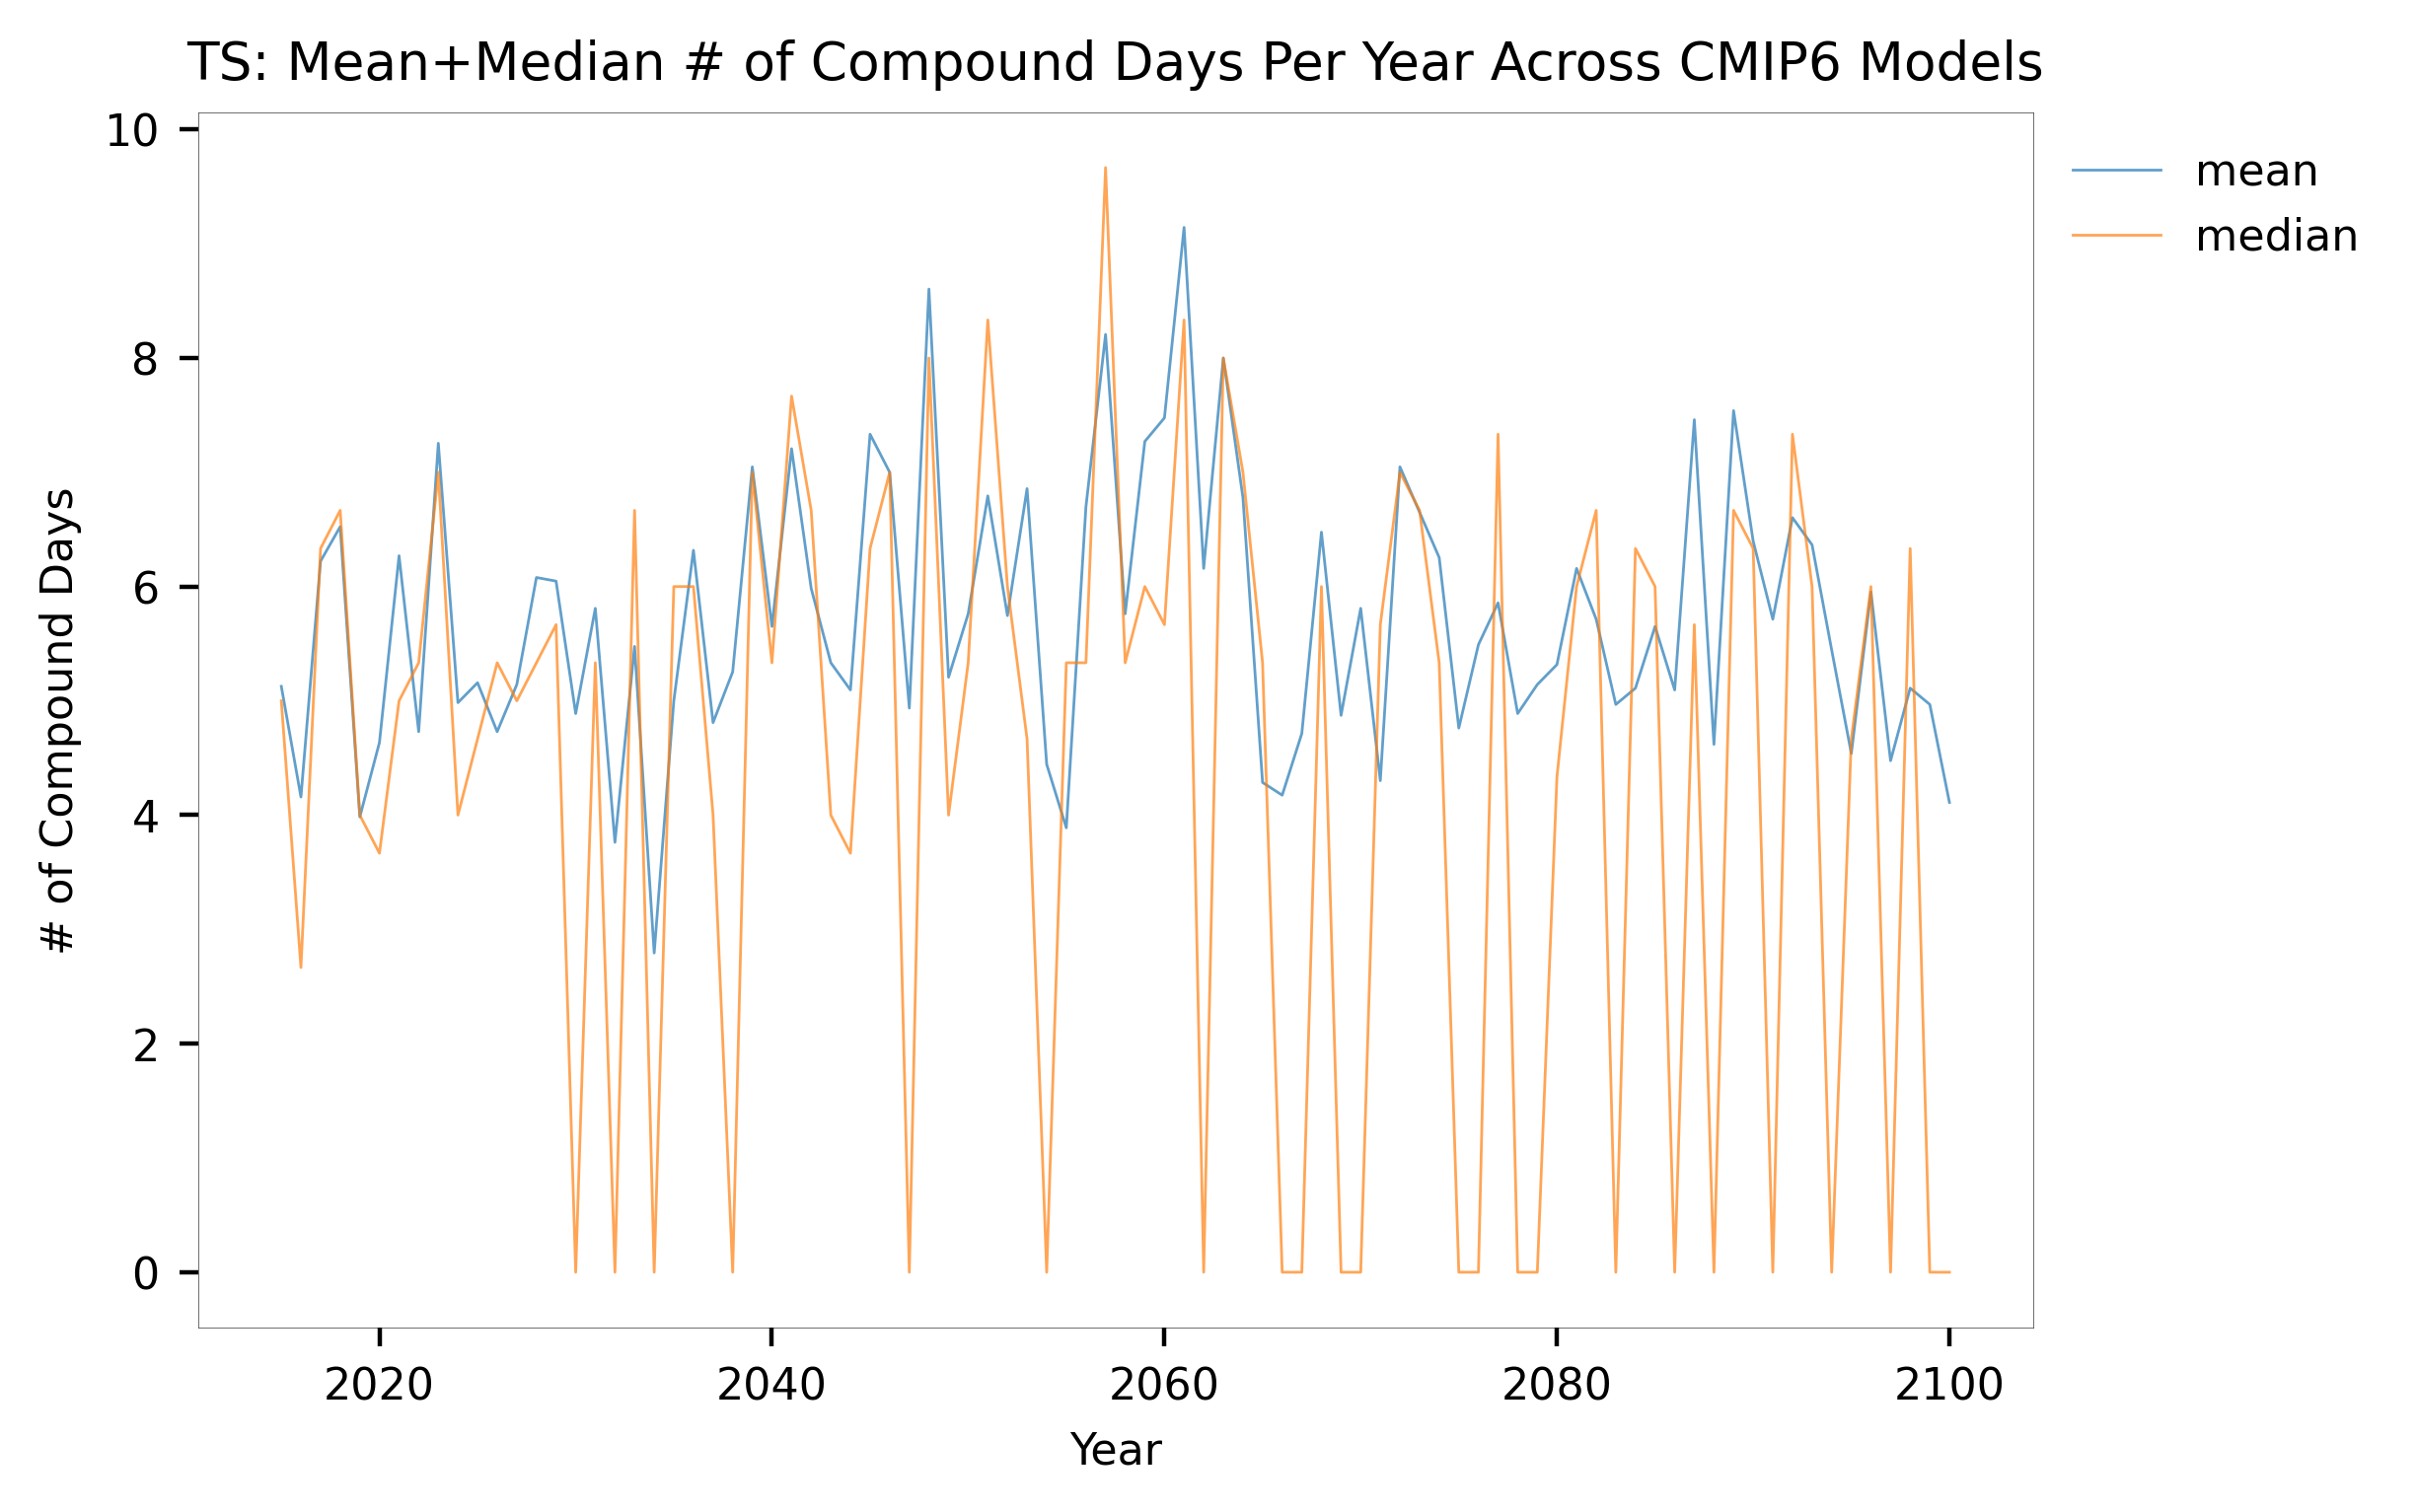

In [7]:
# Get the number of compound events days per year-month
compound_days = (results.filter(regex='_compound$')
                 .groupby(results.index.strftime('%Y-%m')).sum().reset_index())
compound_days.date = pd.to_datetime(compound_days.date)
compound_days = compound_days.set_index('date')

# Dataframe quality check
if len(compound_days) != (2100-2015+1)*len(months):
    raise ValueError(f'Expected {(2100-2015+1)*len(months)} rows, but has {len(compound_days)}')
    
display(compound_days.head(2))

title = '# of Compound Days'
plot_distribution(compound_days, title)
plot_ts(compound_days.groupby(compound_days.index.year).mean(), title, False)

In [8]:
compound_days.describe().T.sort_values('max')

count       mean        std  min  25%  50%    75%  \
INM-CM4-8_compound      258.0   5.236434   9.592591  0.0  0.0  0.0   4.75   
KACE-1-0-G_compound     258.0   1.612403   6.572919  0.0  0.0  0.0   0.00   
NorESM2-MM_compound     258.0   6.550388  10.792317  0.0  0.0  0.0  16.00   
CNRM-ESM2-1_compound    258.0  10.449612  13.033307  0.0  0.0  0.0  25.00   
IPSL-CM6A-LR_compound   258.0   5.011628   9.986560  0.0  0.0  0.0   0.00   
ACCESS-CM2_compound     258.0   4.375969   9.370982  0.0  0.0  0.0   0.00   
EC-Earth3_compound      258.0   5.740310  10.613405  0.0  0.0  0.0   0.00   
ACCESS-ESM1-5_compound  258.0   7.906977  12.280409  0.0  0.0  0.0  20.00   
CMCC-ESM2_compound      258.0   3.488372   8.185701  0.0  0.0  0.0   0.00   
MRI-ESM2-0_compound     258.0   3.631783   8.317629  0.0  0.0  0.0   0.00   
INM-CM5-0_compound      258.0   4.600775  10.045399  0.0  0.0  0.0   0.00   
MPI-ESM1-2-LR_compound  258.0   4.197674   8.982239  0.0  0.0  0.0   0.00   
MPI-ESM1-2-HR_compound  258.0   5.391473   9.866317  0.0  0.0  0.0   6.00   
FGOALS-g3_compound      258.0   5.286822   9.170409  0.0  0.0  0.0  11.00   
GISS-E2-1-G_compound    258.0   5.717054  10.661094  0.0  0.0  0.0   0.00   
MIROC-ES2L_compound     258.0   4.484496   9.898009  0.0  0.0  0.0   0.00   
GFDL-ESM4_compound      258.0   6.352713  10.583171  0.0  0.0  0.0  14.75   
MIROC6_compound         258.0   4.949612   9.753049  0.0  0.0  0.0   0.00   
NorESM2-LM_compound     258.0   5.701550  10.821153  0.0  0.0  0.0   0.00   
CNRM-CM6-1_compound     258.0  10.953488  13.354409  0.0  0.0  0.0  26.75   
BCC-CSM2-MR_compound    258.0   8.399225  12.183404  0.0  0.0  0.0  22.00   

                         max  
INM-CM4-8_compound      30.0  
KACE-1-0-G_compound     30.0  
NorESM2-MM_compound     31.0  
CNRM-ESM2-1_compound    31.0  
IPSL-CM6A-LR_compound   31.0  
ACCESS-CM2_compound     31.0  
EC-Earth3_compound      31.0  
ACCESS-ESM1-5_compound  31.0  
CMCC-ESM2_compound      31.0  
MRI-ESM2-0_compound     31.0  
INM-CM5-0_compound      31.0  
MPI-ESM1-2-LR_compound  31.0  
MPI-ESM1-2-HR_compound  31.0  
FGOALS-g3_compound      31.0  
GISS-E2-1-G_compound    31.0  
MIROC-ES2L_compound     31.0  
GFDL-ESM4_compound      31.0  
MIROC6_compound         31.0  
NorESM2-LM_compound     31.0  
CNRM-CM6-1_compound     31.0  
BCC-CSM2-MR_compound    31.0

## Duration (Max Consecutive Compound Days in a year (june - aug))

INM-CM4-8_compound  INM-CM5-0_compound  NorESM2-MM_compound  \
date                                                                
2015                 NaN                12.0                 11.0   
2016                 NaN                16.0                  NaN   
2017                26.0                 NaN                  NaN   
2018                 3.0                 NaN                 15.0   
2019                 6.0                 NaN                  NaN   

      NorESM2-LM_compound  MIROC6_compound  GFDL-ESM4_compound  \
date                                                             
2015                 14.0              5.0                 NaN   
2016                  NaN              8.0                23.0   
2017                 17.0              NaN                 8.0   
2018                  6.0             12.0                 NaN   
2019                  NaN              9.0                17.0   

      MIROC-ES2L_compound  GISS-E2-1-G_compound  FGOALS-g3_compound  \
date                                                                  
2015                  NaN                  15.0                 2.0   
2016                  NaN                   NaN                 9.0   
2017                 28.0                  23.0                11.0   
2018                  NaN                   NaN                 5.0   
2019                 10.0                   NaN                 NaN   

      MPI-ESM1-2-HR_compound  ...  MPI-ESM1-2-LR_compound  \
date                          ...                           
2015                     NaN  ...                    18.0   
2016                     5.0  ...                     NaN   
2017                     9.0  ...                     8.0   
2018                    11.0  ...                     NaN   
2019                     7.0  ...                     NaN   

      MRI-ESM2-0_compound  CMCC-ESM2_compound  ACCESS-ESM1-5_compound  \
date                                                                    
2015                 19.0                 NaN                    21.0   
2016                 15.0                 2.0                    10.0   
2017                  NaN                17.0                     NaN   
2018                  6.0                13.0                    12.0   
2019                  7.0                 NaN                    24.0   

      EC-Earth3_compound  ACCESS-CM2_compound  IPSL-CM6A-LR_compound  \
date                                                                   
2015                 NaN                 14.0                   21.0   
2016                 NaN                  NaN                    NaN   
2017                 8.0                  5.0                   13.0   
2018                10.0                 11.0                    9.0   
2019                25.0                  2.0                   18.0   

      CNRM-ESM2-1_compound  CNRM-CM6-1_compound  KACE-1-0-G_compound  
date                                                                  
2015                   NaN                  NaN                  NaN  
2016                  15.0                 23.0                  NaN  
2017                  14.0                  NaN                  NaN  
2018                  10.0                 30.0                 30.0  
2019                   NaN                 19.0                  NaN  

[5 rows x 21 columns]

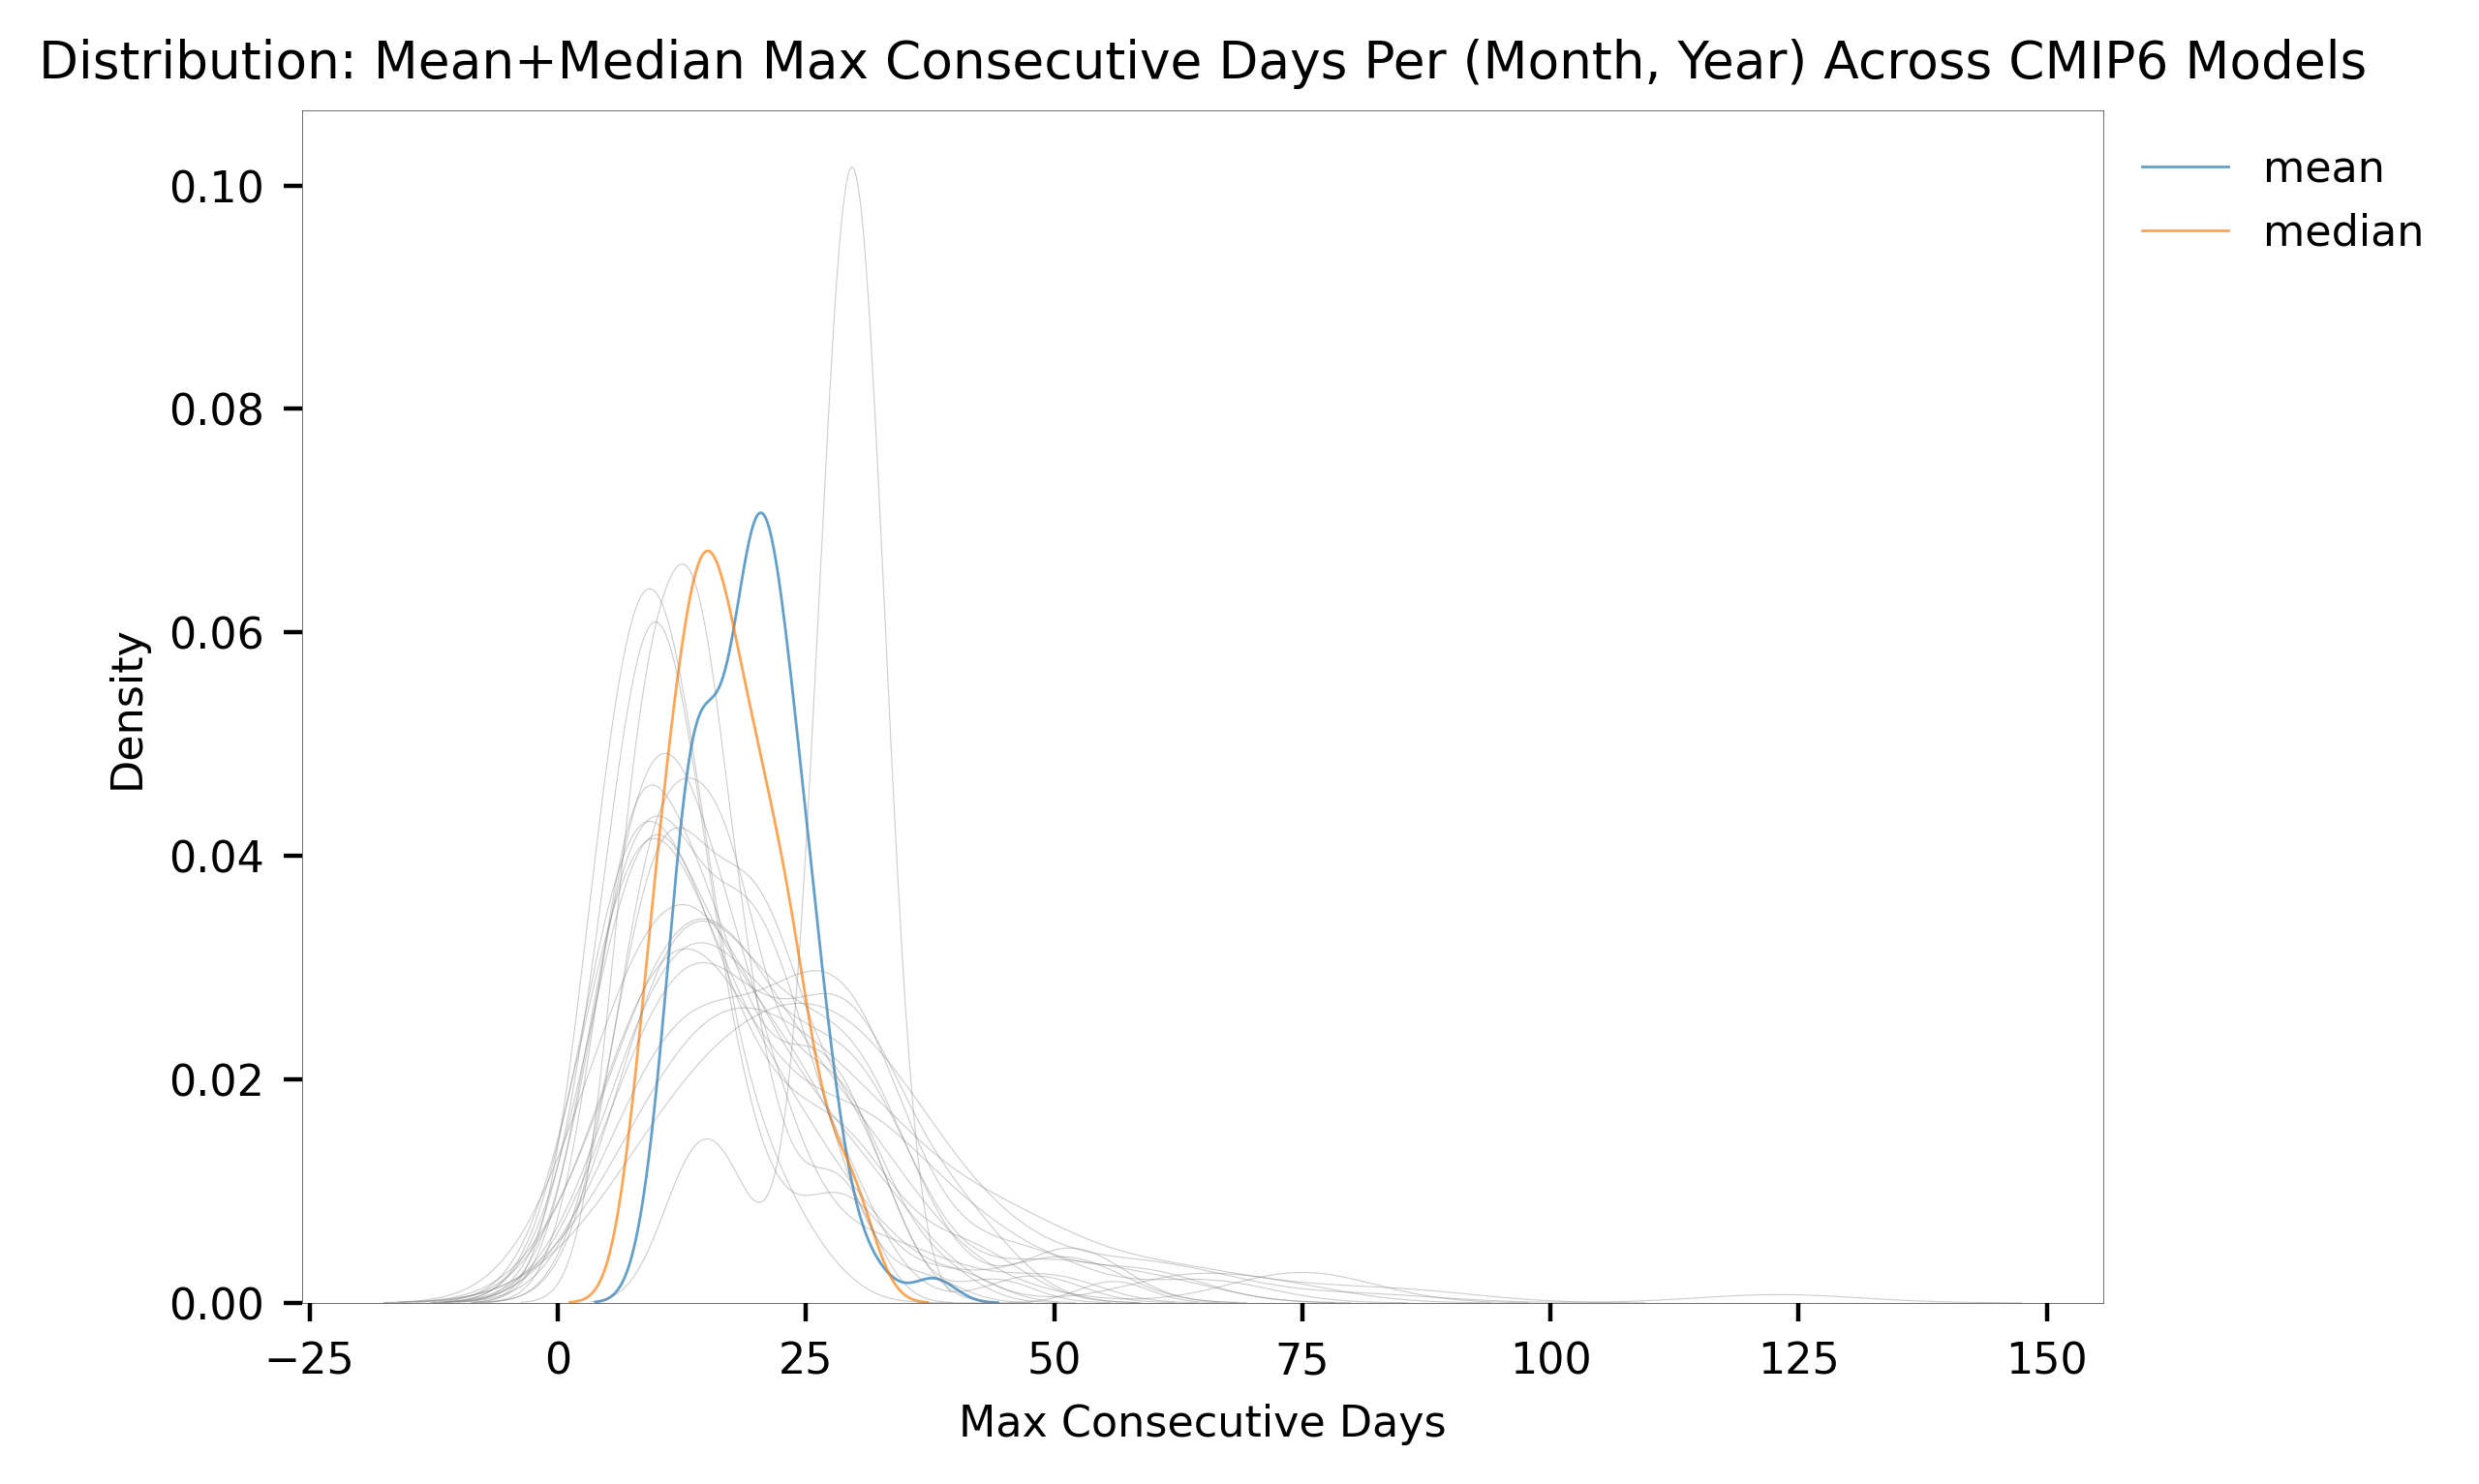

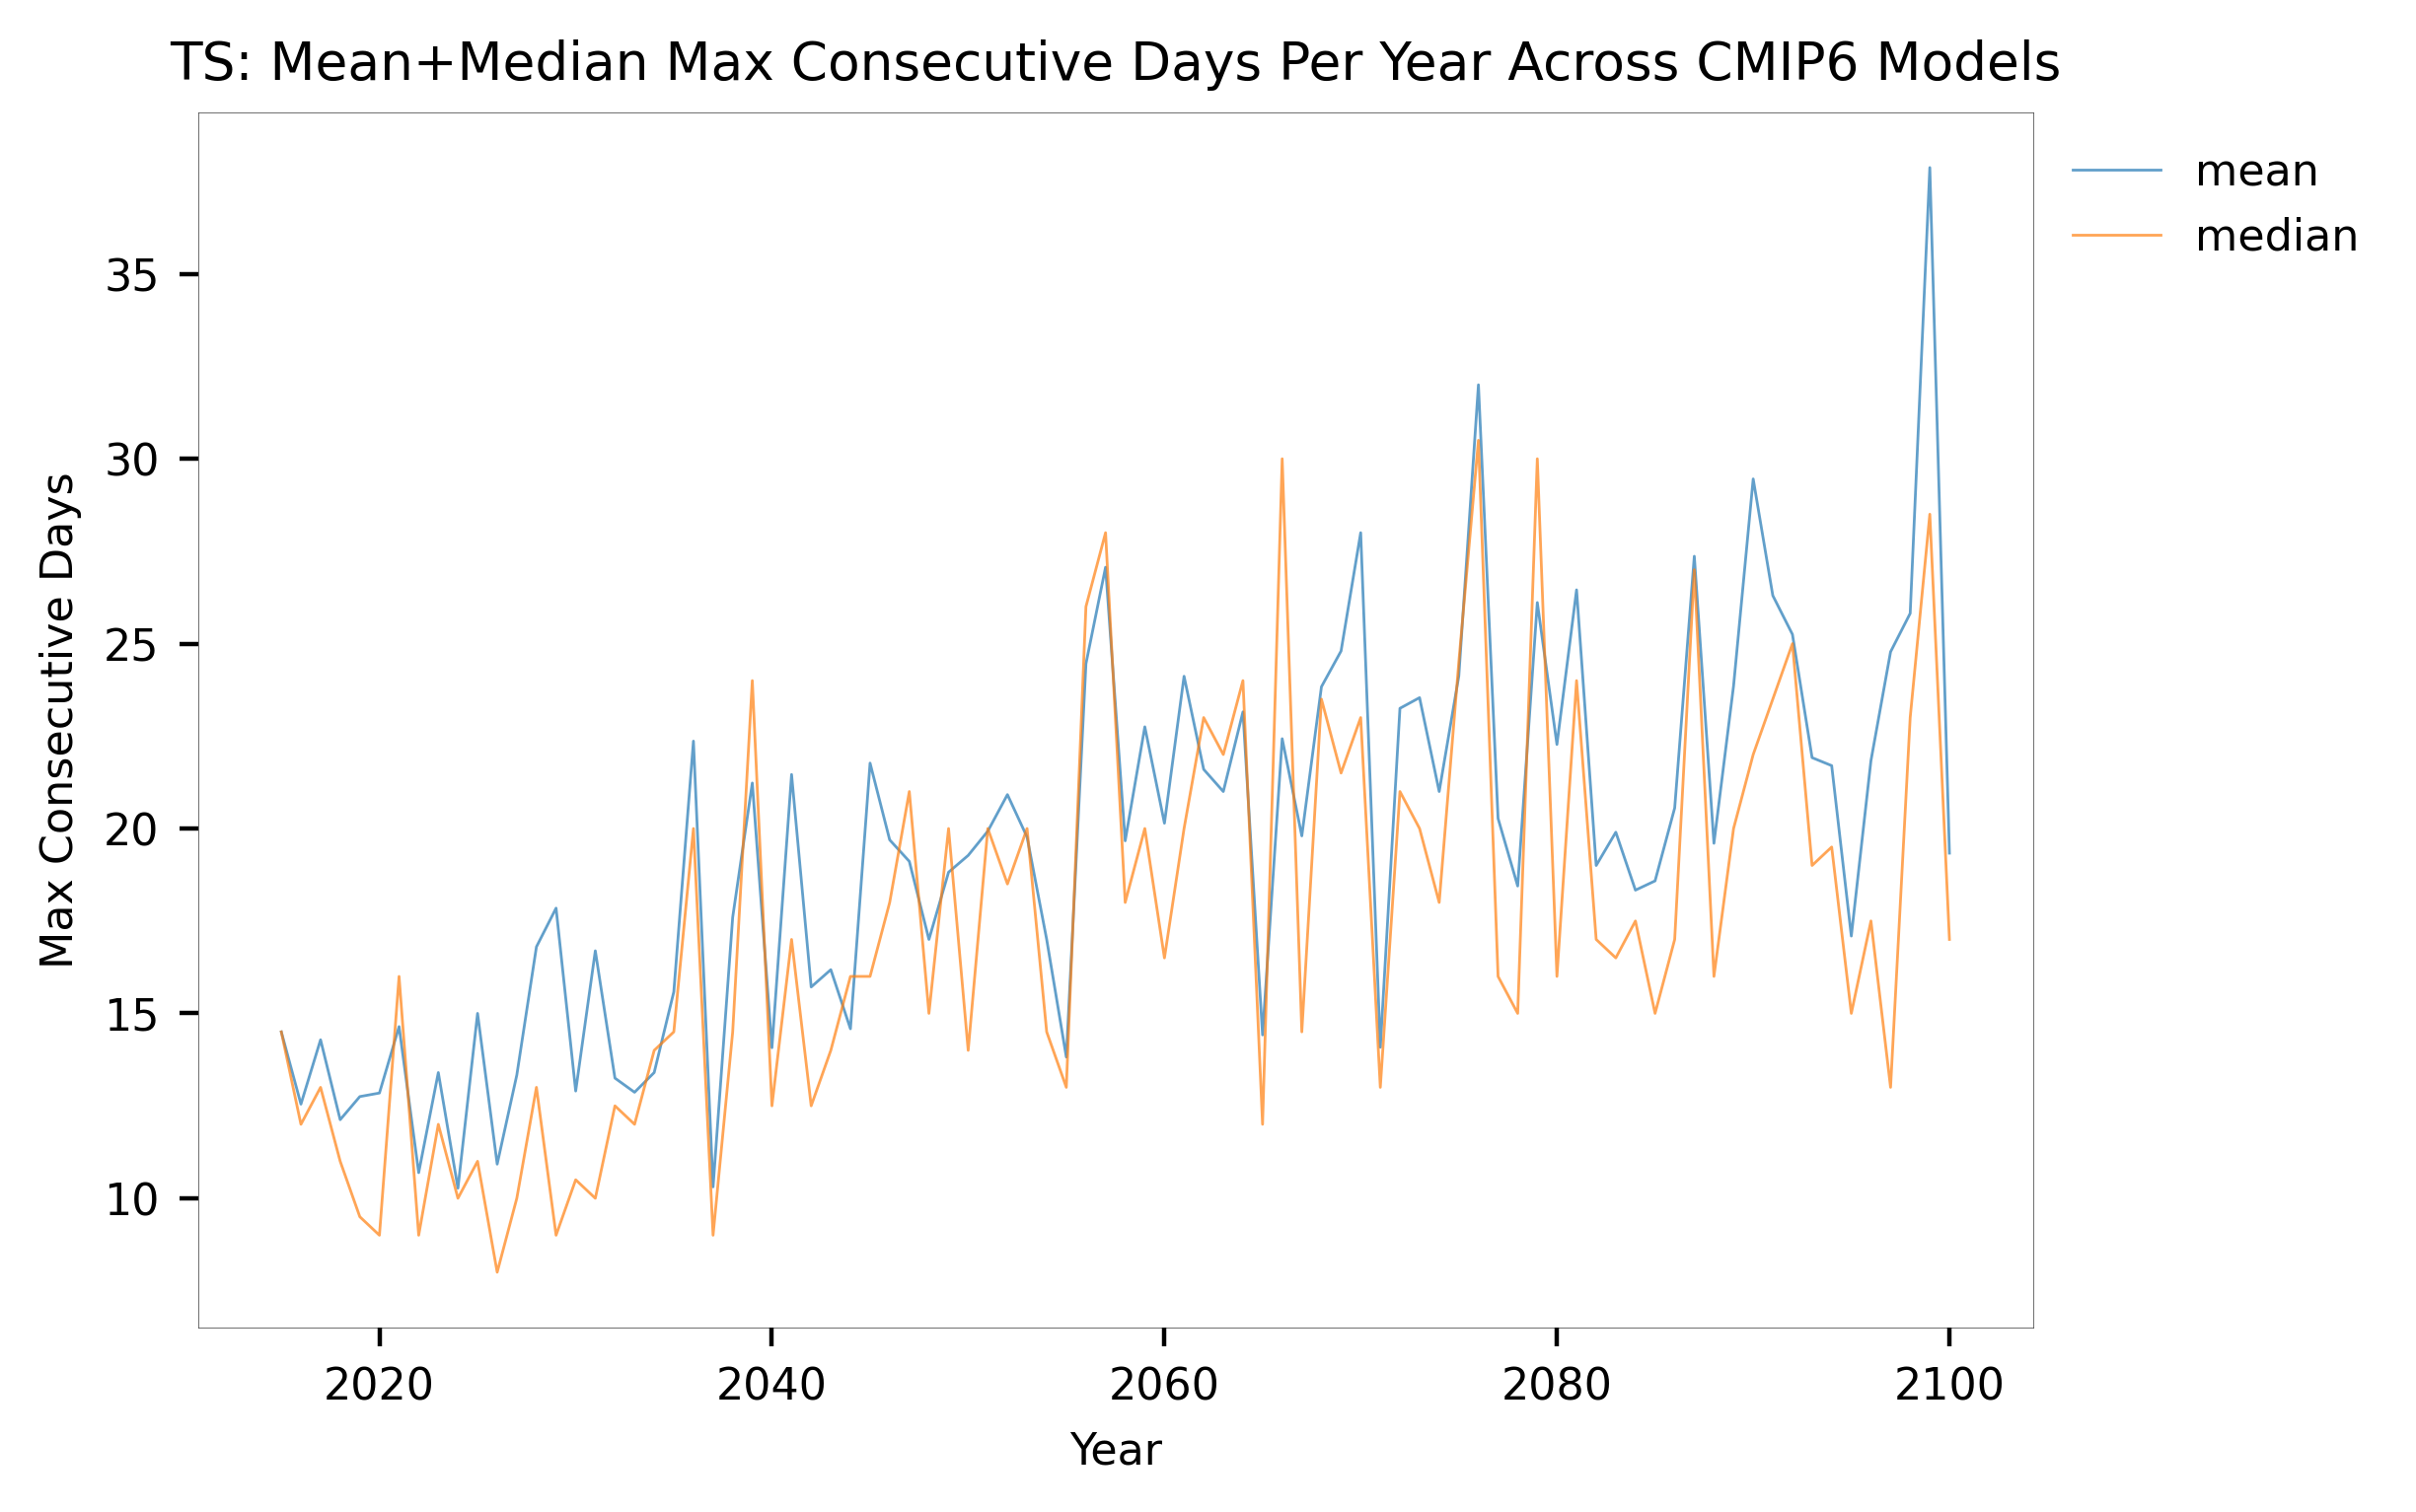

In [9]:
# def filter_non_zero(group):
#     return group[group > 0].tolist()
    
def count_consecutive_true(df):
    # Identify changes in boolean values
    changes = df.ne(df.shift())
    
    # Create groups for consecutive values
    groups = changes.cumsum()
    
    # Count consecutive True values
    counts = df.groupby(groups).cumsum()
    
    # return counts.groupby(df.index.year).apply(filter_non_zero)
    # only considers #(days) > 0
    return counts.replace(0, np.nan).groupby(df.index.year).agg('max')

# Apply the function to all boolean columns
duration = results.filter(regex='_compound').apply(count_consecutive_true)
display(duration.head())

title = 'Max Consecutive Days'
plot_distribution(duration, title)
plot_ts(duration.groupby(duration.index).mean(), 
                  title, False)

## Severity = percentiles - daily values

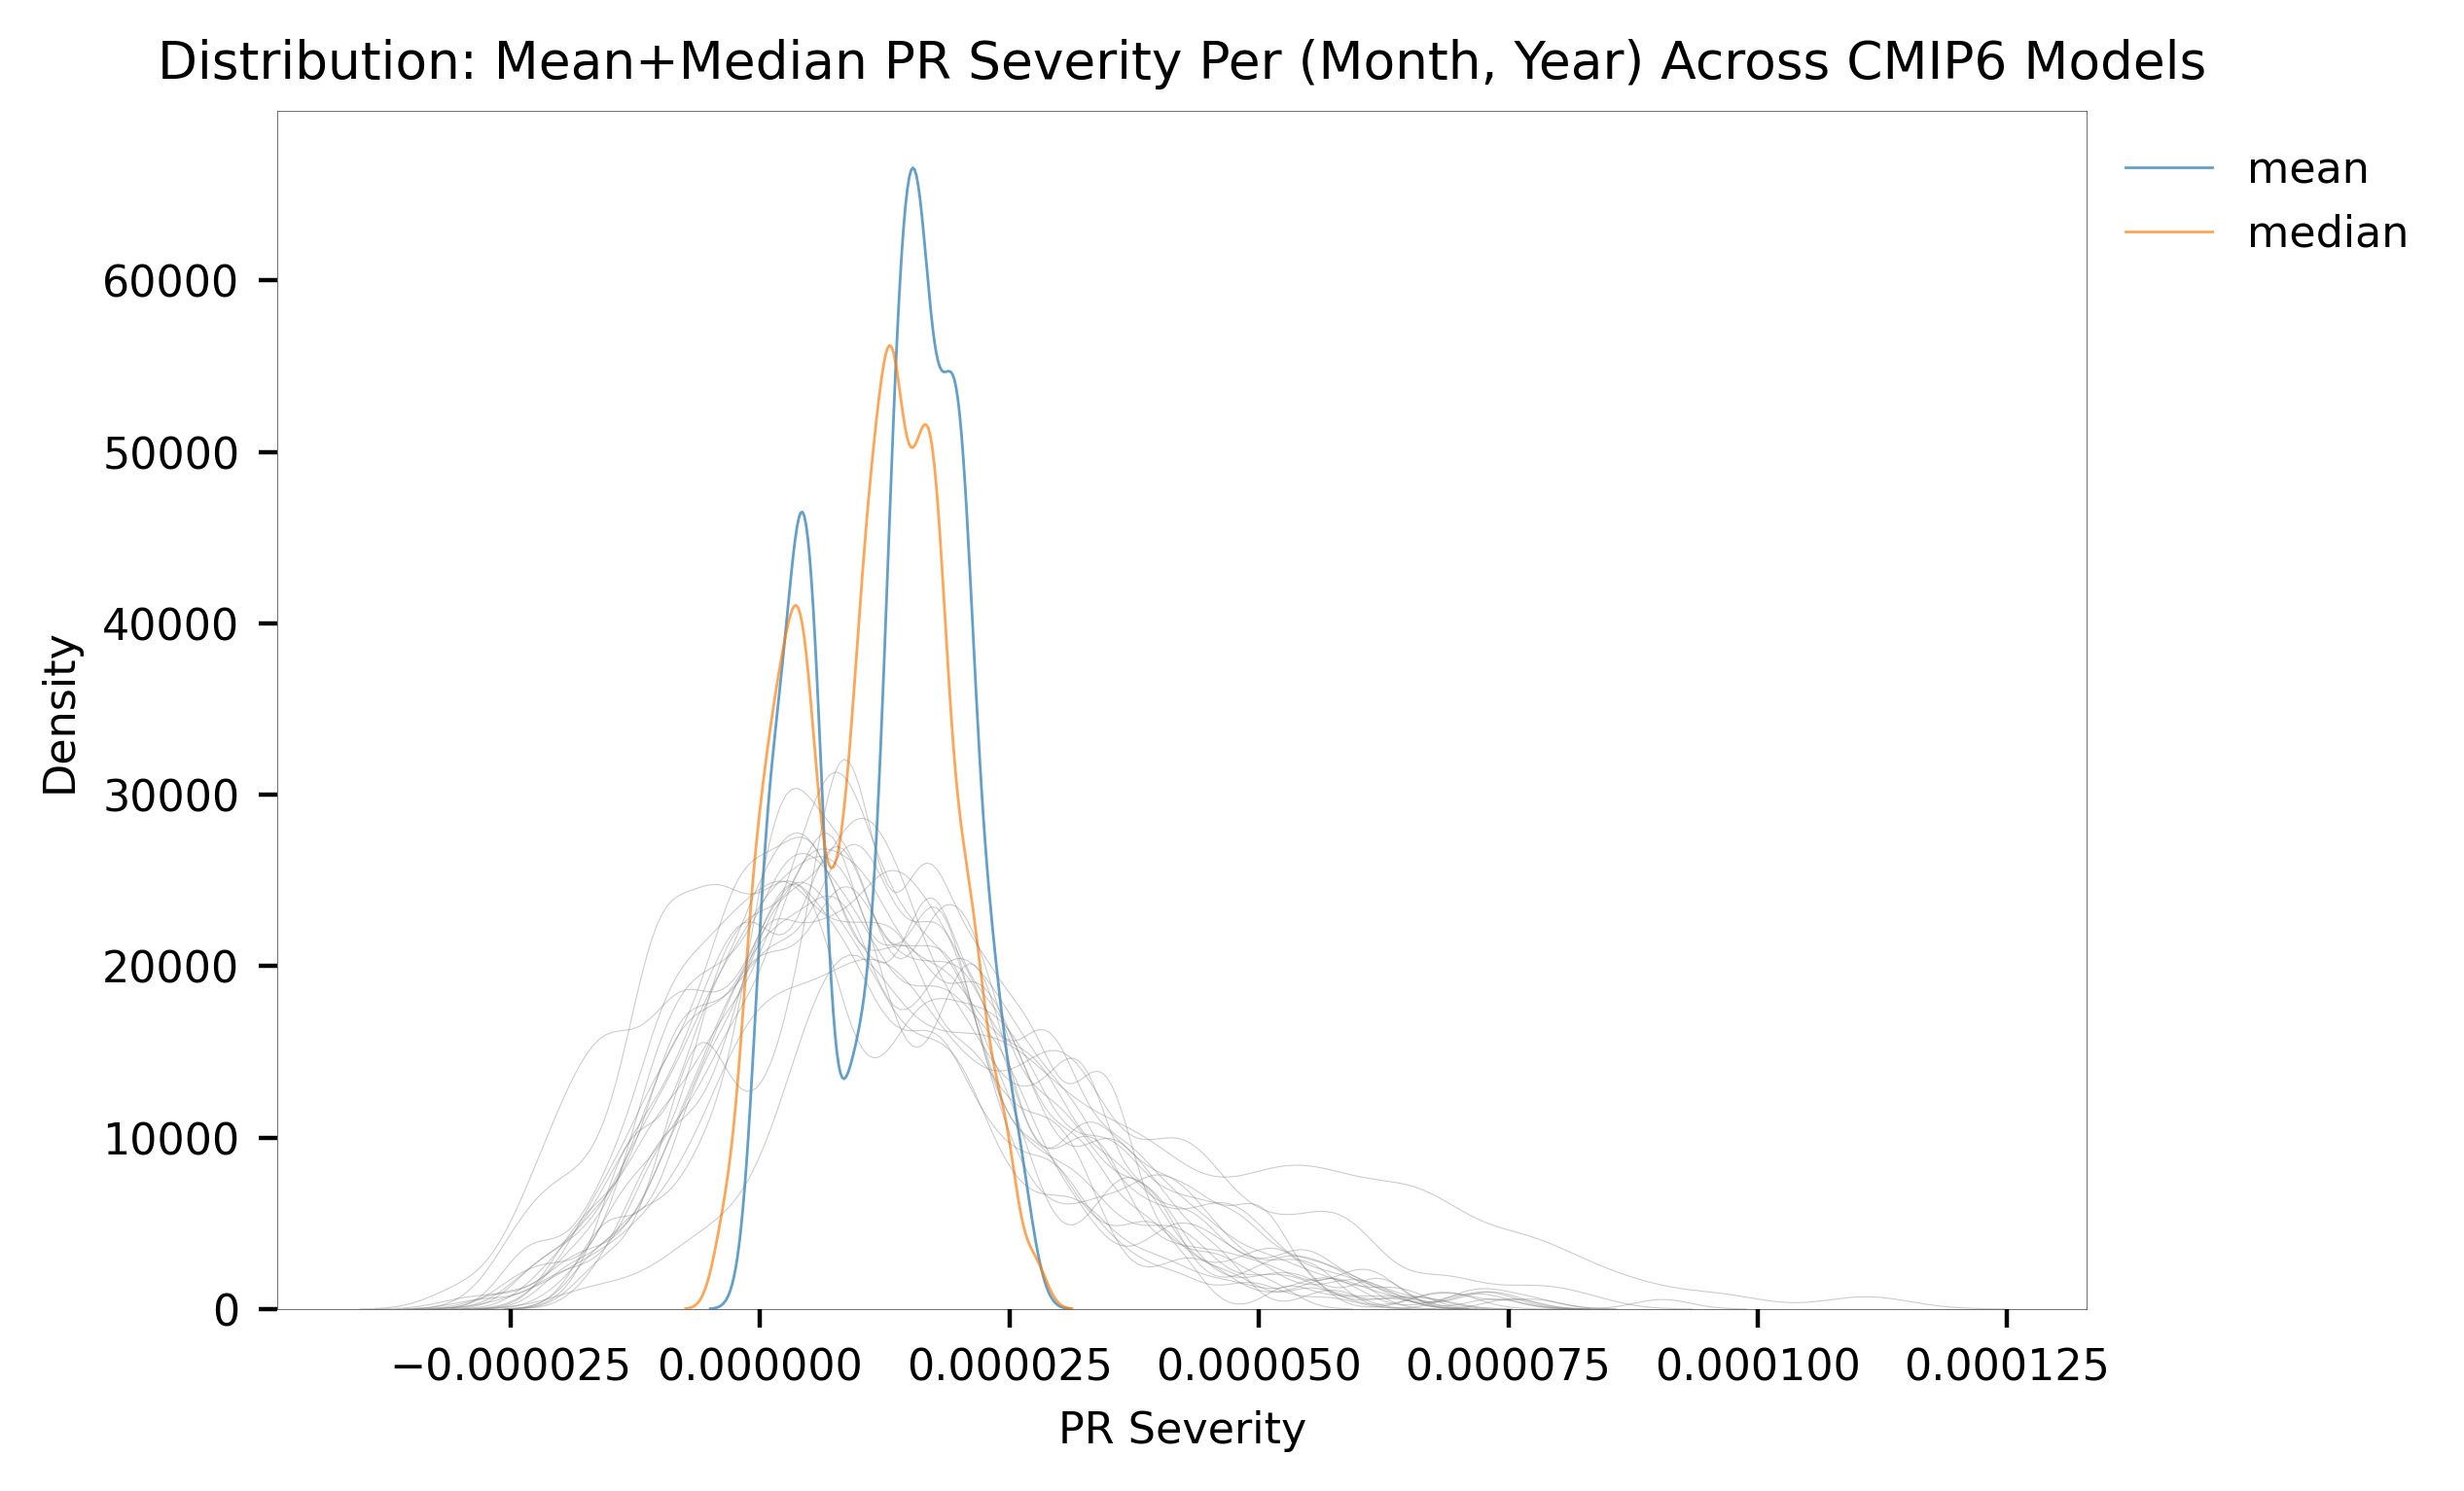

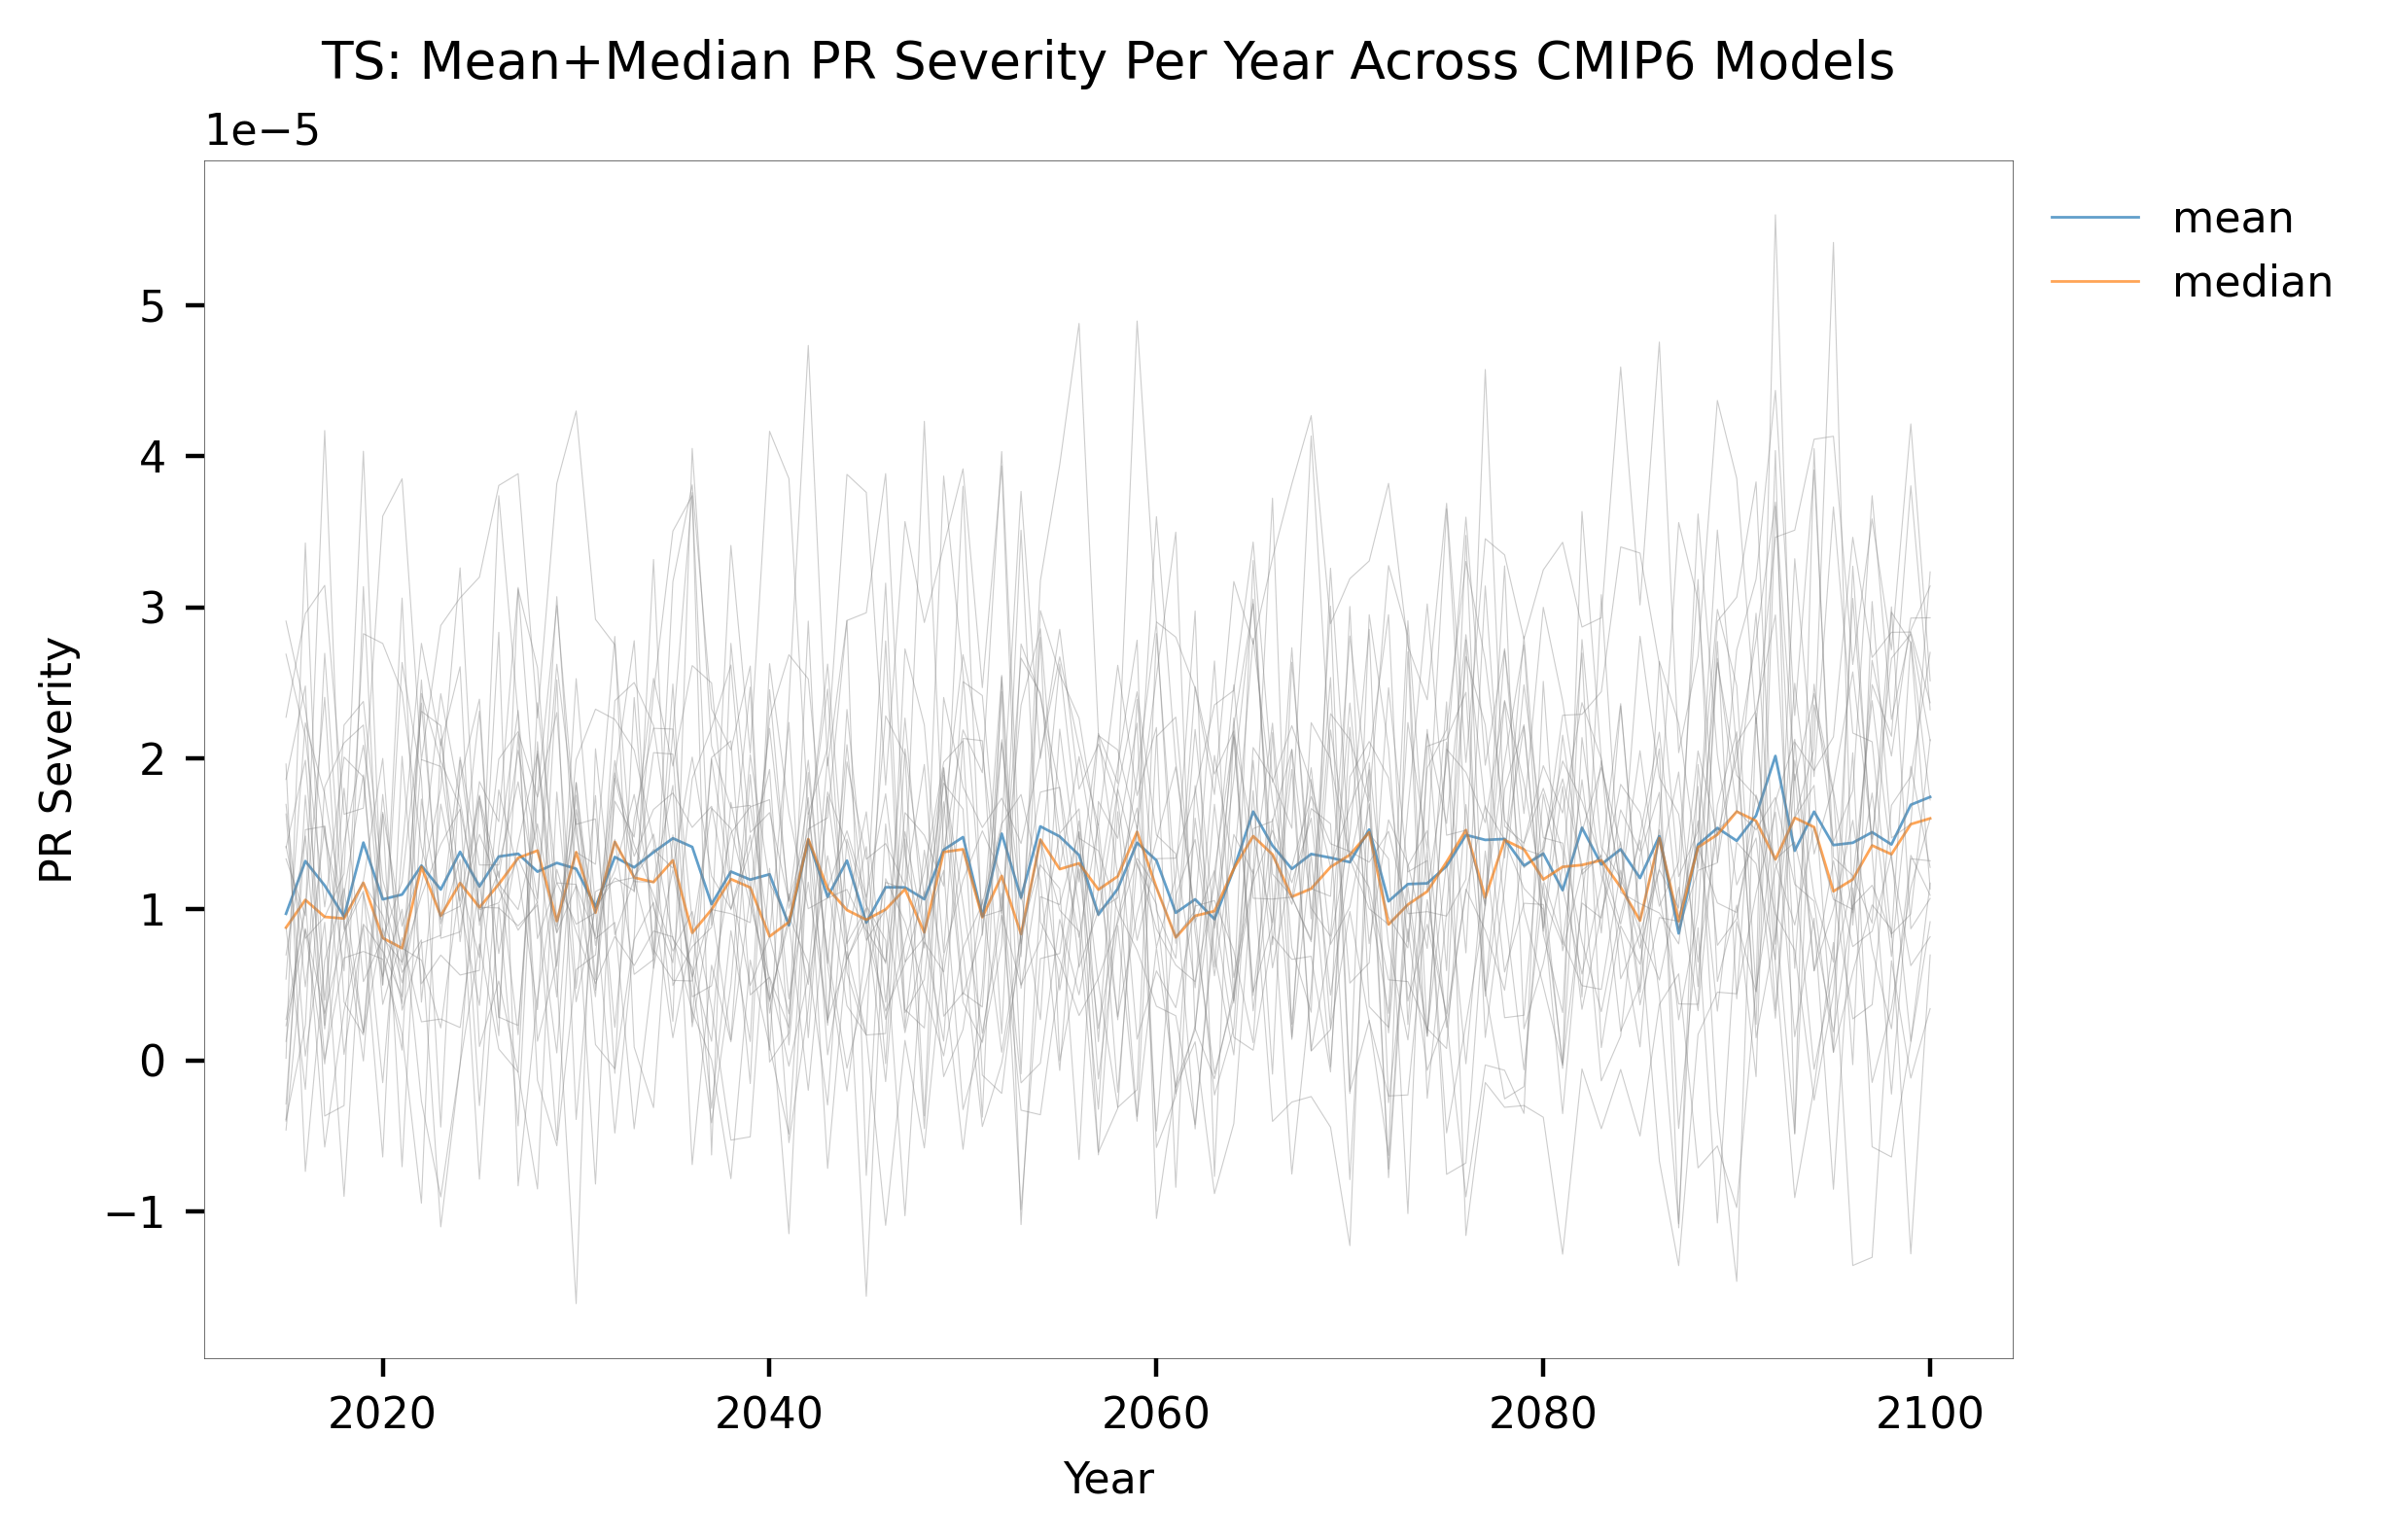

In [10]:
title = 'PR Severity'
df = results.filter(regex=f'_pr_severity')
plot_distribution(df, title)
plot_ts(df.groupby(df.index.year).mean(), title, True)

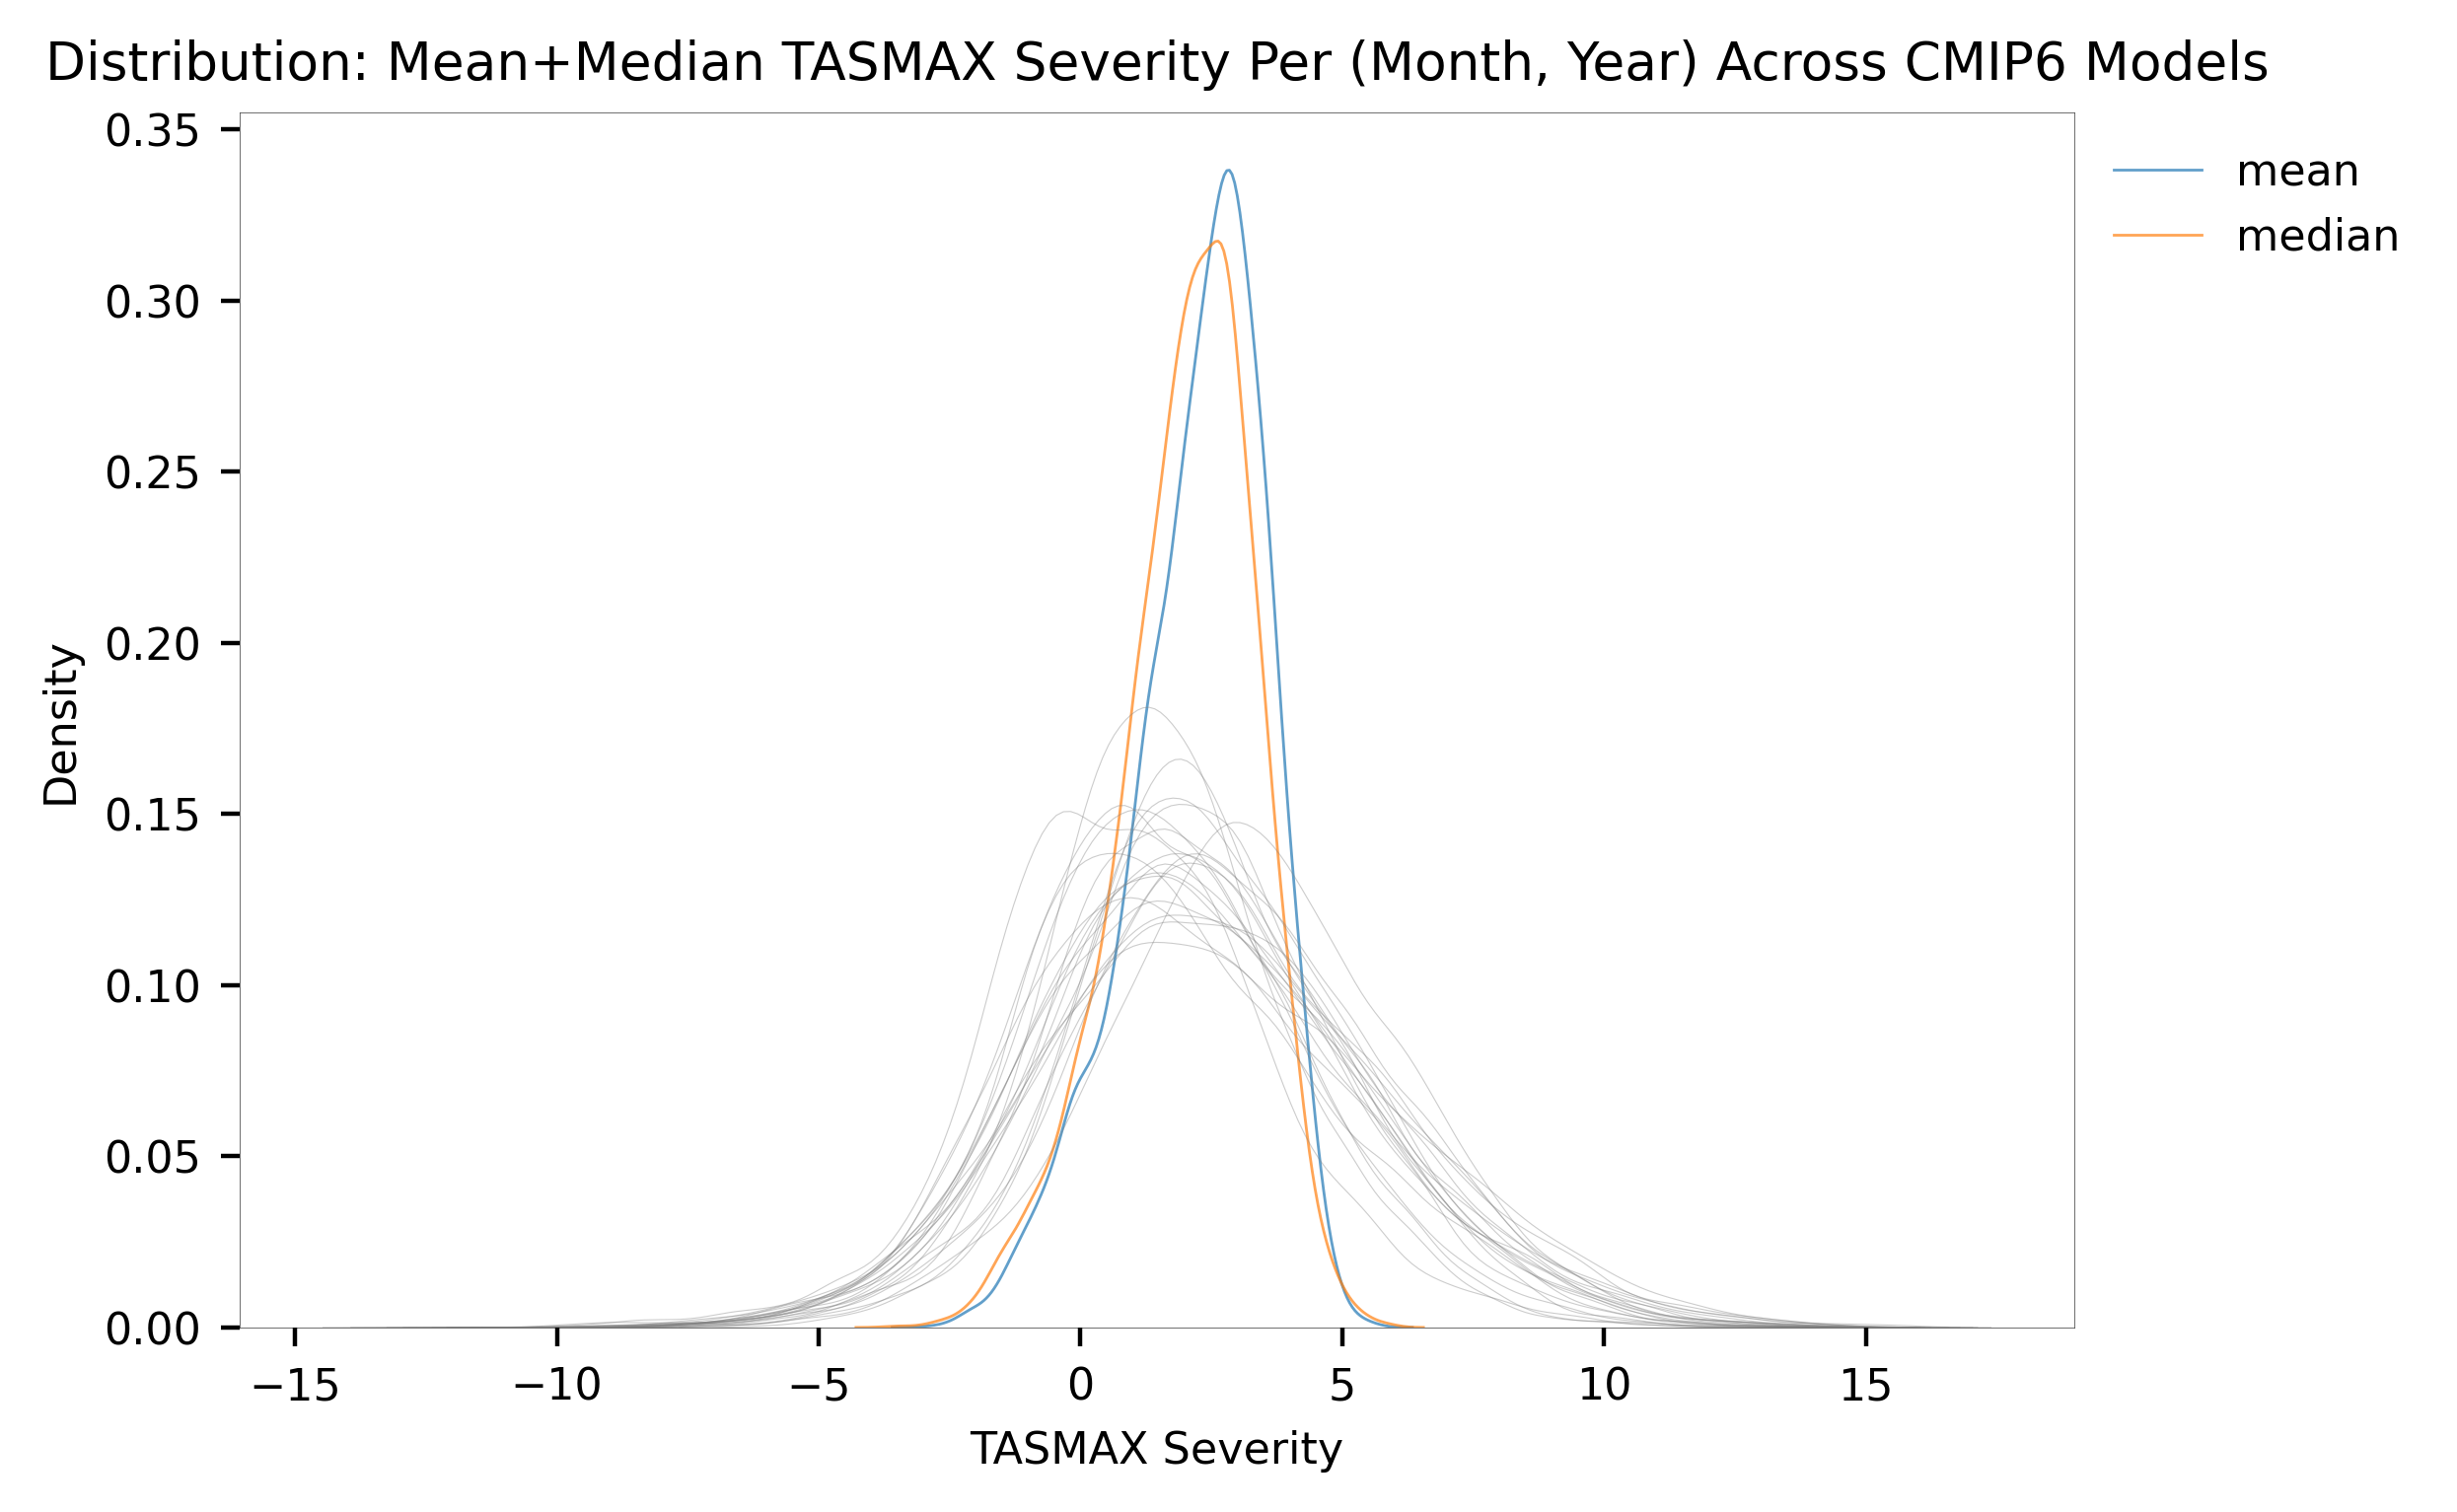

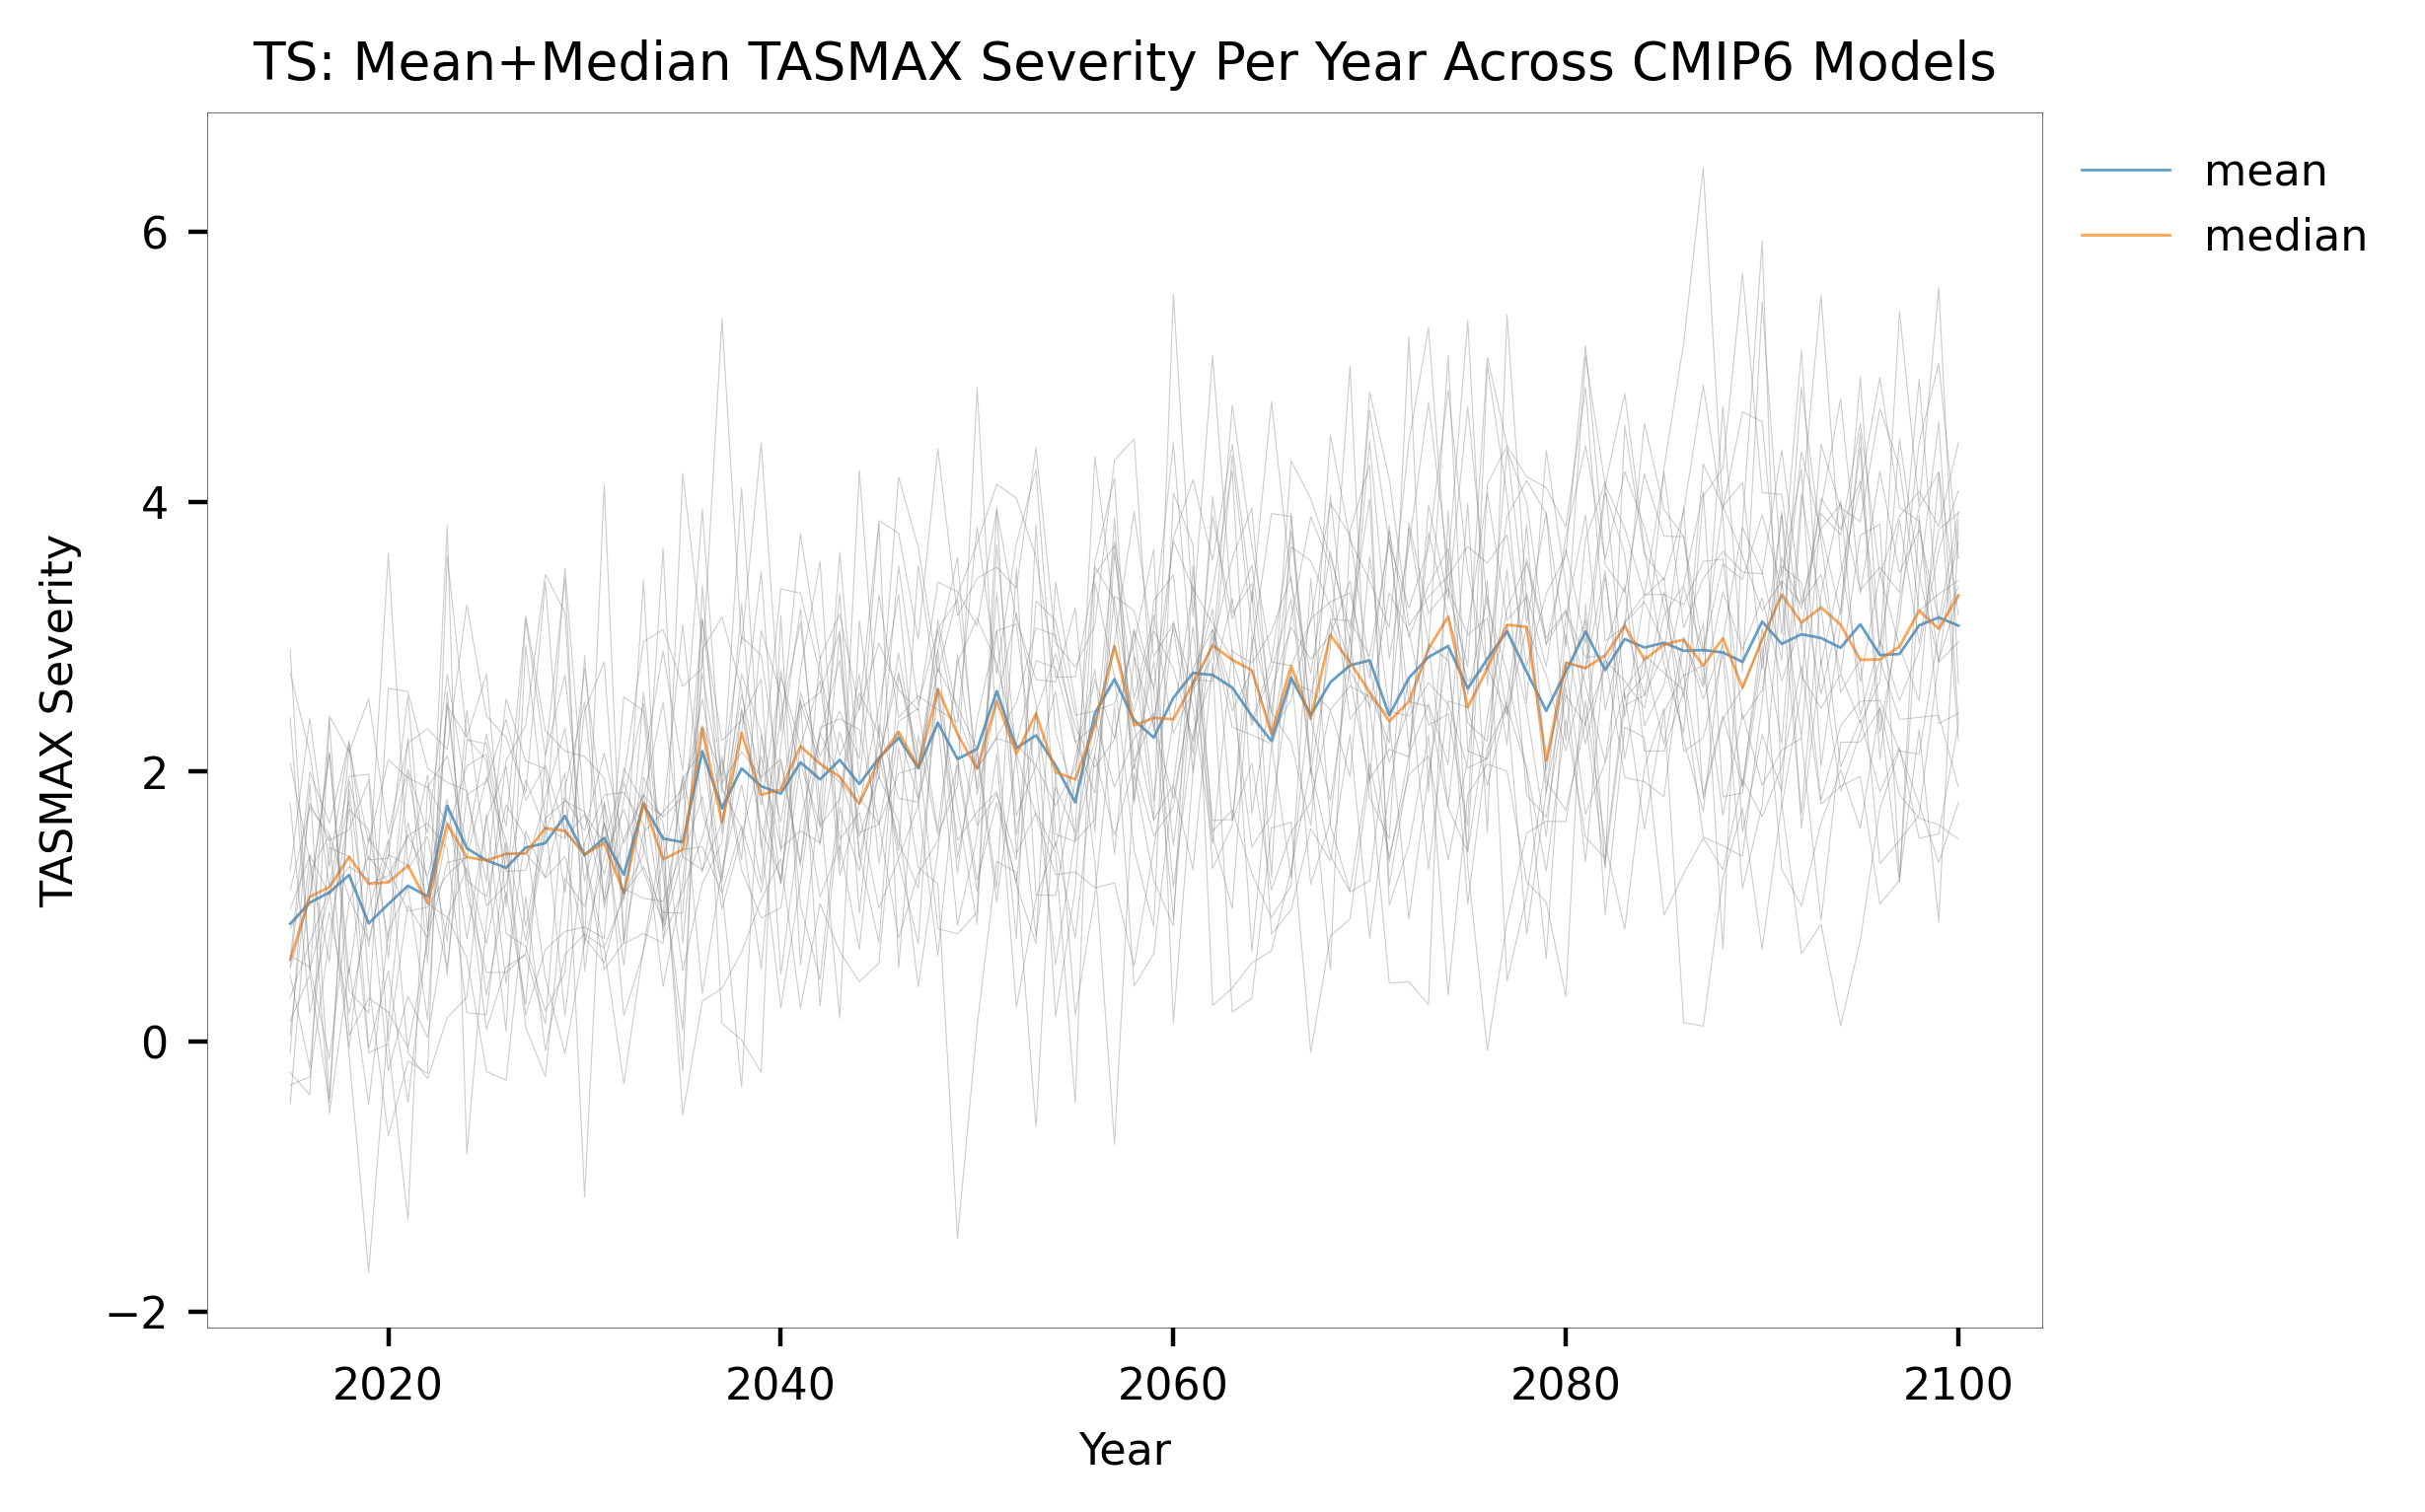

In [11]:
title = 'TASMAX Severity'
df = results.filter(regex=f'_tasmax_severity')
plot_distribution(df, title)
plot_ts(df.groupby(df.index.year).mean(), title, True)